# Bank Churn Prediction

Background and Context

Banks that provide financial services are concerned about customer turnover.  These businesses want to understand what influences a customer's decision to leave.

Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

Data Dictionary

* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, 
                  using bank products regularly, making transactions, etc )
* Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )
                    1=Yes ( Customer left the bank )

### Import Libraries

In [1]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

import time
import random

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# Sets the maximum column
pd.set_option('display.max_colwidth', None)

# Libraries to help with data visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

# Libraries to split data, impute missing values 
from sklearn.impute import SimpleImputer

# To do one-hot encoding
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Import Linear Regression machine learning library
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Libtune to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    mean_squared_error,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_confusion_matrix,
    classification_report,
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# importing tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam, SGD, RMSprop
from keras import layers,initializers,losses,backend
from keras.layers import Dense, Dropout, Input, Activation, InputLayer, BatchNormalization# Accuracy (Root Mean Squared Error)
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from kerastuner.tuners import RandomSearch



<IPython.core.display.Javascript object>

In [2]:
## Install Keras Tuner
#!pip install keras-tuner 

<IPython.core.display.Javascript object>

### Define Functions

Create function to save classification report to a dataframe.

In [3]:
classification_reports = []

def save_classification_report(report,model):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        #print(len(row_data))
        #print(row_data)
        if (len(row_data) == 6):
            if (row_data[0] == '    accuracy'):
                row['model'] = ''
                row['class'] = ''
                row['precision'] = ''
                row['recall'] = ''
                row['f1_score'] = ''
                row['support'] = ''
                row['accuracy'] = float(row_data[4])
                report_data.append(row)
            else:
                row['model'] = model
                row['class'] = row_data[1]
                row['precision'] = float(row_data[2])
                row['recall'] = float(row_data[3])
                row['f1_score'] = float(row_data[4])
                row['support'] = float(row_data[5])
                row['accuracy'] = ''
                report_data.append(row)

    cr_dataframe = pd.DataFrame.from_dict(report_data)
    #print(cr_dataframe)
    #cr_dataframe.to_csv('classification_report.csv', index = False)
    classification_reports.append(cr_dataframe)


<IPython.core.display.Javascript object>

Create lists to store classification model results

In [4]:
model_names = []
accuracy_train = []
accuracy_val = []
accuracy_test = []
recall_train = []
recall_val = []
recall_test = []
precision_train = []
precision_val = []
precision_test = []
f1_train = []
f1_val = []
f1_test = []
roc_train = []
roc_val = []
roc_test = []


<IPython.core.display.Javascript object>

Create a function to save the classification model performance data

In [5]:
def save_model(results): 
    model_names.append(results[0])
    accuracy_train.append(results[1])
    accuracy_val.append(results[2])
    accuracy_test.append(results[3])
    recall_train.append(results[4])
    recall_val.append(results[5])
    recall_test.append(results[6])
    precision_train.append(results[7])
    precision_val.append(results[8])
    precision_test.append(results[9])
    f1_train.append(results[10])
    f1_val.append(results[11])
    f1_test.append(results[12])
    roc_train.append(results[13])
    roc_val.append(results[14])
    roc_test.append(results[15])
    

<IPython.core.display.Javascript object>

Create lists to store regression model results

In [6]:
lr_model_names = []
RMSE_train = []
RMSE_val = []
RMSE_test = []
MAE_train = []
MAE_val = []
MAE_test = []
R_Squared_train = []
R_Squared_val = []
R_Squared_test = []
Adj_R_Squared_train = []
Adj_R_Squared_val = []
Adj_R_Squared_test = []
MAPE_train = []
MAPE_val = []
MAPE_test = []


<IPython.core.display.Javascript object>

Create a function to save the regression model performance data

In [7]:
def save_lr_model(results): 
    lr_model_names.append(results[0])
    RMSE_train.append(results[1])
    RMSE_val.append(results[2])
    RMSE_test.append(results[3])
    MAE_train.append(results[4])
    MAE_val.append(results[5])
    MAE_test.append(results[6])
    R_Squared_train.append(results[7])
    R_Squared_val.append(results[8])
    R_Squared_test.append(results[9])
    Adj_R_Squared_train.append(results[10])
    Adj_R_Squared_val.append(results[11])
    Adj_R_Squared_test.append(results[12])
    MAPE_train.append(results[13])
    MAPE_val.append(results[14])
    MAPE_test.append(results[15])

<IPython.core.display.Javascript object>

Create lists to store RandomSearchCV model results

In [8]:
rscv_model_names = []
rscv_model_scores = []
rscv_model_parameters = []

<IPython.core.display.Javascript object>

Create a function to save the RandomSearchCV model results

In [9]:
def save_rscv_model(results): 
    rscv_model_names.append(results[0])
    rscv_model_scores.append(results[1])
    rscv_model_parameters.append(results[2])
    

<IPython.core.display.Javascript object>

Create a function to display the ROC (receiver operating characteristic) curve

In [10]:
def display_ROC(model,x_set,y_set):
    
    # example: display_ROC(model,x_train,y_train)
    
    y_pred_proba = model.predict_proba(x_set)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_set, y_pred_proba)
    auc = metrics.roc_auc_score(y_set, y_pred_proba)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


<IPython.core.display.Javascript object>

Function to display the intersect point of Precision and Recall to potentially find a better threshold for model improvement

In [11]:
def plot_prec_recall_vs_tresh(model,predictor,target):

    # example: plot_prec_recall_vs_tresh(model,X_train,y_train)

    y_scores = model.predict_proba(predictor)[:, 1]
    prec, rec, tre = metrics.precision_recall_curve(target, y_scores,)

    plt.plot(tre, prec[:-1], "b--", label="precision")
    plt.plot(tre, rec[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.figure(figsize=(10, 7))
    plt.show()

<IPython.core.display.Javascript object>

Create a function to display the coefficients of the logistic regression model sent as a parameter

In [12]:
def show_coef(model,dataset):
   # example: show_coef(lrmodel,x_train)
     
   m_coef = pd.DataFrame(model.coef_[0], dataset.columns, columns=['coef'])
   m_coef.loc[:, "Odds"] = np.exp(m_coef.coef) # Odd ratio
   m_coef['Probability'] = m_coef['Odds']/(1+m_coef['Odds'])
   m_coef['%_Change_Of_Odds']=(np.exp(m_coef.coef)-1)*100
   pd.options.display.float_format = '{:.2f}'.format
   m_coef = m_coef.sort_values(by="Odds", ascending=False)
   pd.set_option("display.max_columns", None)
   print("Intercept:",model.intercept_)
   print(" ")
   print(m_coef)
   

<IPython.core.display.Javascript object>

Function to calculate classification model scores and output the results

In [13]:
def calculate_scores(model_name,model,train,val,test,train_y,val_y,test_y):
    
    # example: model_scores = calculate_scores('model-name',model,X_train,X_test,X_val,y_train,y_test,y_val)

    results=[] # list to store results
   
    # predicting using the independent variables
    trainpred = model.predict(train)
    valpred = model.predict(val)
    testpred = model.predict(test)

    trainacc = round(accuracy_score(train_y, trainpred),2)  # to compute training Accuracy
    trainrecall = round(recall_score(train_y, trainpred),2)  # to compute training Recall
    trainprecision = round(precision_score(train_y, trainpred),2)  # to compute training Precision
    trainf1 = round(f1_score(train_y, trainpred),2)  # to compute training F1-score
    trainroc = round(roc_auc_score(train_y,trainpred),2) # to compute Receiver Operating Characteristic curve score
     
    valacc = round(accuracy_score(val_y, valpred),2)  # to compute validation Accuracy
    valrecall = round(recall_score(val_y, valpred),2)  # to compute validation Recall
    valprecision = round(precision_score(val_y, valpred),2)  # to compute validation Precision
    valf1 = round(f1_score(val_y, valpred),2)  # to compute validation F1-score
    valroc = round(roc_auc_score(val_y,valpred),2) # to compute Receiver Operating Characteristic curve score
    
    testacc = round(accuracy_score(test_y, testpred),2)  # to compute Test Accuracy
    testrecall = round(recall_score(test_y, testpred),2)  # to compute Test Recall
    testprecision = round(precision_score(test_y, testpred),2)  # to compute Test Precision
    testf1 = round(f1_score(test_y, testpred),2)  # to compute Test F1-score
    testroc = round(roc_auc_score(test_y,testpred),2) # to compute Receiver Operating Characteristic curve score
    
    print("Accuracy on Training set : ",trainacc)
    print("Accuracy on Val set : ",valacc)
    print("Accuracy on Test set : ",testacc)
    print(" ")
    print("Recall on Training set : ",trainrecall)
    print("Recall on Val set : ",valrecall)
    print("Recall on Test set : ",testrecall)
    print(" ")
    print("Precision on Training set : ",trainprecision)
    print("Precision on Val set : ",valprecision)
    print("Precision on Test set : ",testprecision)
    print(" ")
    print("F1 on Training set : ",trainf1)
    print("F1 on Val set : ",valf1)
    print("F1 on Test set : ",testf1)
    print(" ")
    print("ROC Score on Training set : ",trainroc)
    print("ROC Score on Val set : ",valroc)
    print("ROC Score on Test set : ",testroc)
    print(" ")
    
    #print(" ")
    #print(classification_report(test_y,probtest))
    
   # save the results to the list    
    results.extend((model_name,trainacc,valacc,testacc,trainrecall,valrecall,testrecall,trainprecision,valprecision,testprecision,trainf1,valf1,testf1,trainroc,valroc,testroc))
        
    return results # return the scores

<IPython.core.display.Javascript object>

Function to calculate linear regression model scores and output the results

In [14]:
def calculate_lr_scores(lr_model_name,model,train_x,val_x,test_x,train_y,val_y,test_y):
    
    # example: model_scores = calculate_lr_scores('model-name',model,X_train,X_val,X_test,y_train,y_val,y_test)

    results = [] # list to store lr model results
    
    #"RMSE": rmse,
    #"MAE": mae,
    #"R-squared": r2,
    #"Adj. R-squared": adjr2,
    #"MAPE": mape,
     
    pred_train = model.predict(train_x)
    pred_val = model.predict(val_x)
    pred_test = model.predict(test_x)
    
    train_rmse=np.sqrt(metrics.mean_squared_error(train_y,pred_train))
    val_rmse=np.sqrt(metrics.mean_squared_error(val_y,pred_val))
    test_rmse=np.sqrt(metrics.mean_squared_error(test_y,pred_test))
    
    train_mae = metrics.mean_absolute_error(train_y, pred_train) 
    val_mae = metrics.mean_absolute_error(val_y, pred_val) 
    test_mae = metrics.mean_absolute_error(test_y, pred_test) 
        
    train_r2=metrics.r2_score(train_y,pred_train)
    val_r2=metrics.r2_score(val_y,pred_val)
    test_r2=metrics.r2_score(test_y,pred_test)
       
    n1 = train_x.shape[0]
    k1 = train_x.shape[1]
    
    n2 = val_x.shape[0]
    k2 = val_x.shape[1]
    
    n3 = test_x.shape[0]
    k3 = test_x.shape[1]
    
    train_adjr2 = 1 - ((1 - train_r2) * (n1 - 1) / (n1 - k1 - 1))  
    val_adjr2 = 1 - ((1 - val_r2) * (n2 - 1) / (n2 - k2 - 1))  
    test_adjr2 = 1 - ((1 - test_r2) * (n3 - 1) / (n3 - k3 - 1))  
    
    train_mape = metrics.mape_score(train_y, pred_train)
    val_mape = metrics.mape_score(val_y, pred_val)
    test_mape = metrics.mape_score(test_y, pred_test)    

    print("RMSE on Training set : ",train_rmse)
    print("RMSE on Val set : ",val_rmse)
    print("RMSE on Test set : ",test_rmse)
    print(" ")
    print("MAE on Training set : ",train_mae)
    print("MAE on Val set : ",val_mae)
    print("MAE on Test set : ",test_mae)
    print(" ")
    print("R-squared on Training set : ",train_r2)
    print("R-squared on Val set : ",val_r2)
    print("R-squared on Test set : ",test_r2)
    print(" ")
    print("Adj. R-squared on Training set : ",train_adjr2)
    print("Adj. R-squared on Val set : ",val_adjr2)
    print("Adj. R-squared on Test set : ",test_adjr2)
    print(" ")
    print("MAPE on Training set : ",train_mape)
    print("MAPE on Val set : ",val_mape)
    print("MAPE on Test set : ",test_mape)

   # save the results to the list    
    results.extend((lr_model_name,train_rmse,val_rmse,test_rmse,train_mae,val_mae,test_mae,train_r2,val_r2,test_r2,train_adjr2,val_adjr2,test_adjr2,train_mape,val_mape,test_mape))
        
    return results # return the scores

<IPython.core.display.Javascript object>

Function to display a confusion matrix

In [15]:
def print_confusion_matrix(model,predictors,target, class_names, figsize = (10,7), fontsize=14): 
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure will be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
        model: classifier
        predictors: independent variables
        target: dependent variable

        confusion_matrix: numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. Similarly constructed ndarrays can also be used.
        class_names: list An ordered list of class names, in the order they index the given confusion matrix.
        figsize: tuple A 2-long tuple, the first value determining the hor size of the ouputed figure, the second determining the vert size. Defaults to (10,7).
        fontsize: int Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    #plt.figure(figsize=(6, 4))
    #sns.heatmap(cm, annot=labels, fmt="")
    #plt.ylabel("True label")
    #plt.xlabel("Predicted label")

    df_cm = pd.DataFrame(
        cm, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=labels, fmt="")
        #heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    # return fig

<IPython.core.display.Javascript object>

Original function to display a confusion matrix

In [16]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

Another alternate function for a confusion matrix

In [17]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments

    Example:
    #Calculating the confusion matrix 
    from sklearn.metrics import confusion_matrix
    cm=confusion_matrix(y_test, y_pred)
    labels = ['True Positive','False Negative','False Positive','True Negative']
    categories = [ 'Not Changing Job','Changing Job']
    make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    
    if title:
        plt.title(title)

<IPython.core.display.Javascript object>

Function to plot a boxplot and a histogram along the same scale.

In [18]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    

<IPython.core.display.Javascript object>

Function to display a labeled barplot

In [19]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

Function to display a stacked bar chart of categorical variables vs a dependent variable

In [20]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

In [21]:
#def stacked_barchart(x,dep):
#    tab1 = pd.crosstab(x,data[dep],margins=True)
#    print(tab1)
#    print('-'*120)
#    tab = pd.crosstab(x,data[dep],normalize='index')
#    tab.plot(kind='bar',stacked=True,figsize=(10,5))
#    plt.legend(loc='lower left', frameon=True)
#    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
#    plt.ylabel('Percentage')
#    plt.show()

<IPython.core.display.Javascript object>

Function to plot distributions

In [22]:
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for " + target + " = " + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for " + target + " = " + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t " + target)
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t " + target )
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

Create a function to summarize outliers by column

In [23]:
def get_outliers(data,col_name):  # identify column outliers with interquartile range 
    # calculate interquartile range
    print(col_name)
    q25 = np.percentile(data[col_name], 25)
    q75 = np.percentile(data[col_name], 75)
    q100 = np.percentile(data[col_name],100)
    iqr = q75 - q25

    print('mean=%.3f stdv=%.3f' % (np.mean(data[col_name]), np.std(data[col_name])))

    print('Percentiles: 25th=%.2f, 75th=%.2f, 100th=%.2f, IQR=%.2f' % (q25, q75, q100, iqr))

    # calculate the outlier cutoff
    cutoff = iqr * 1.5
    lower =  q25 - cutoff
    upper = q75 + cutoff

    # identify outliers
    outliers = [x for x in data[col_name] if x < lower or x > upper]

    print('Outliers = %d' % len(outliers))

    # remove outliers
    nonoutliers = [x for x in data if x >= lower and x <= upper]
    print('Non-outliers = %d' % len(nonoutliers))

<IPython.core.display.Javascript object>

Define a function to treat the outliers

In [24]:
def treat_outliers(data, col_name):
    print('Treating outliers in ',col_name)
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    data[col_name] = np.clip(data[col_name],low,high)
    return data

<IPython.core.display.Javascript object>

Function to calculate the importance of features in the decision tree and print a text report

In [25]:
def print_feature_importance_values(model,x_train):
    # importance of features in the tree building ( The importance of a feature is computed as the
    # (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )
    print(pd.DataFrame(model.feature_importances_, columns=["Imp"], index=x_train.columns).sort_values(by="Imp", ascending=False))

<IPython.core.display.Javascript object>

Function to calculate the importance of features in the decision tree and visualize the output

In [26]:
def graph_feature_importance_values(model,x_train):
    feature_names = x_train.columns.to_list()     ## creating a list of column names
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(12, 12))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.show()


<IPython.core.display.Javascript object>

Function to display the decision tree

In [27]:
def create_decision_tree(model,dataset):
    feature_names = dataset.columns.to_list()     ## creating a list of column names
    plt.figure(figsize=(20, 30))
    # from sklearn import tree is required
    out = tree.plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
    )
    # below code will add arrows to the decision tree split if they are missing
    for o in out:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor("black")
            arrow.set_linewidth(1)
    plt.show()

<IPython.core.display.Javascript object>

Function to generate a text report showing the rules of a decision tree

In [28]:
def create_decision_tree_text_report(model,x_train,display_weights):
    # exmaple: create_decision_tree_text_report(dTree,x_train,True)
    feature_names = x_train.columns.to_list()     ## creating a list of column names
    # from sklearn import tree is required
    print(tree.export_text(model, feature_names=feature_names, show_weights=display_weights))

<IPython.core.display.Javascript object>

Function to display classification model results

In [29]:
def display_model_results():

  #  lists = [model_names,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1_train,f1_test,roc_train,roc_test]

    # create dataFrame after zipping lists, with columns specified 
    #dmr = pd.DataFrame(list(zip(model_names,accuracy_train,accuracy_val,accuracy_test,recall_train,recall_val,recall_test,precision_train,precision_val,precision_test,f1_train,f1_val,f1_test,roc_train,roc_val,roc_test)), columns =['Model', 'Acc_Train','Acc_Val','Acc_Test','Rec_Train','Rec_Val','Rec_Test','Pre_Train','Pre_Val','Pre_Test','F1_Train','F1_Val','F1_Test','ROC_Train','ROC_Val','ROC_Test'])  
    dmr = pd.DataFrame(list(zip(model_names,accuracy_train,accuracy_val,accuracy_test,recall_train,recall_val,recall_test,precision_train,precision_val,precision_test,f1_train,f1_val,f1_test,roc_train,roc_val,roc_test)), columns =['Model', 'Acc_Tr','Acc_Val','Acc_Tst','Rec_Tr','Rec_Val','Rec_Tst','Pre_Tr','Pre_Val','Pre_Tst','F1_Tr','F1_Val','F1_Tst','ROC_Tr','ROC_Val','ROC_Tst'])  
    print(dmr.to_string()) # this allows the whole row to be printed on one line

<IPython.core.display.Javascript object>

Function to display linear regression model results

In [30]:
def display_lr_model_results():

    # lists = [lr_model_names,RMSE_train,RMSE_test,MAE_train,MAE_test,R_Squared_train,R_Squared_test,Adj_R_Squared_train,Adj_R_Squared_test,MAPE_train,MAPE_test]

    # create dataFrame after zipping lists, with columns specified 
    dmr = pd.DataFrame(list(zip(lr_model_names,RMSE_train,RMSE_val,RMSE_test,MAE_train,MAE_val,MAE_test,R_Squared_train,R_Squared_val,R_Squared_test,Adj_R_Squared_train,Adj_R_Squared_val,Adj_R_Squared_test,MAPE_train,MAPE_val,MAPE_test)), columns =['Model', 'RMSE_Train','RMSE_Val','RMSE_Test','MAE_Train','MAE_Val','MAE_Test','R_Squared_Train','R_Squared_Val','R_Squared_Test','Adj_R_Squared_Train','Adj_R_Squared_Val','Adj_R_Squared_Test','MAPE_Train','MAPE_Val','MAPE_Test']) 
    print(dmr.to_string()) # this allows the whole row to be printed on one line

<IPython.core.display.Javascript object>

Oringinal function for computing model performance

In [31]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

Function to display the unique values of categorical features

In [32]:
def print_unique_cat_features(data):
    datatypes = data.dtypes # <class 'pandas.core.series.Series'>
    categorycols = pd.Series()
    list1 = []

    for index, value in datatypes.items():
    
        #print(f"Feature : {index}, Type: {value}")
        #print(value.type)
    
        #if value.type is np.float64:
        #   print(f"Feature : {index}, Value : {value}")
    
        #if value.type is np.int64:
        #    print(f"Feature : {index}, Value : {value}")
    
        if value.type is pd.core.dtypes.dtypes.CategoricalDtypeType:
            #print(f"Feature : {index}, Value : {value}")
            categorycols[index] = (value.categories.values)
            list1.append((value))

    print(categorycols)

    #for i in list1:
    #    print(i.categories)
    
    # <class 'numpy.int64'>
    # <class 'numpy.float64'>

<IPython.core.display.Javascript object>

Function to process RandomSearchCV queries

In [33]:
def get_rscv_results(name,estimator,parameters,X,y,n_iters=10,scoring='accuracy',cv=5,verbose=2):

    # Example:  rscv_results = get_rscv_results('AdaBoost',model5,m5_parameters,X_train,y_train,n_iters=10,scoring='accuracy',cv=5,verbose=2)

    results = []

    # Run the random search
    rscv = RandomizedSearchCV(estimator, param_distributions=parameters,n_iter=n_iters, scoring=scoring,cv=cv, random_state = 1, n_jobs = -1, verbose = verbose)
    rscv_result = rscv.fit(X,y)

    rscv_params = str(rscv_result.best_params_) # best combination of parameters
    rscv_score = round(rscv_result.best_score_,2) # best cross validation score
    rscv_score = str(rscv_score) 

    print('Model =',name)
    print('CV Score =',rscv_score)
    print('Parameters =',rscv_params)

    # save the results to the list    
    results.extend((name,rscv_score,rscv_params))
    
    return results


<IPython.core.display.Javascript object>

Function to display RandomSearchCV results

In [34]:
def display_rscv_results():

    # create dataFrame after zipping lists, with columns specified 
    dmr = pd.DataFrame(list(zip(rscv_model_names,rscv_model_scores,rscv_model_parameters)), columns =['Model', 'Score','Parameters'])  
    print(dmr.to_string()) # this allows the whole row to be printed on one line

<IPython.core.display.Javascript object>

######################### MAIN

Read the data source.

In [35]:
source = pd.read_csv('C://Python//Introduction To Neural Networks//Project7//churn.csv')

<IPython.core.display.Javascript object>

In [36]:
data = source.copy()

<IPython.core.display.Javascript object>

Perform the usual sanity shecks.

In [37]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<IPython.core.display.Javascript object>

In [38]:
data.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


<IPython.core.display.Javascript object>

### Understand the shape of the dataset.

In [39]:
data.shape

(10000, 14)

<IPython.core.display.Javascript object>

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


<IPython.core.display.Javascript object>

Mostly numerical features with a few string objects.

Check for duplicate rows in the data

In [41]:
data.duplicated().sum()

0

<IPython.core.display.Javascript object>

No duplicated rows found.

In [42]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<IPython.core.display.Javascript object>

No null values found.

View an inital statistical summary

In [43]:
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


<IPython.core.display.Javascript object>

Average credit score is 650.  Mean age of customers is ~39 and a tenure of 5 years.

## Data Pre-Processing


Drop the RowNumber,CustomerId, and Surname features as they are not needed.

In [44]:
data.drop('RowNumber', axis=1, inplace=True) 
data.drop('CustomerId', axis=1, inplace=True) 
data.drop('Surname', axis=1, inplace=True) 

<IPython.core.display.Javascript object>

Create a list of numerical features.

In [45]:
numcols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited']

<IPython.core.display.Javascript object>

Create a list of categorical features

In [46]:
catcols = ['Geography','Gender']

<IPython.core.display.Javascript object>

# EDA

### Univariate analysis

### Create histograms and boxplots for the numercial features

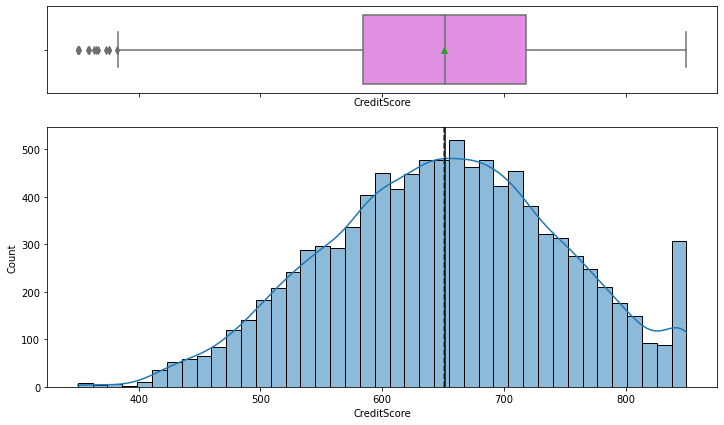

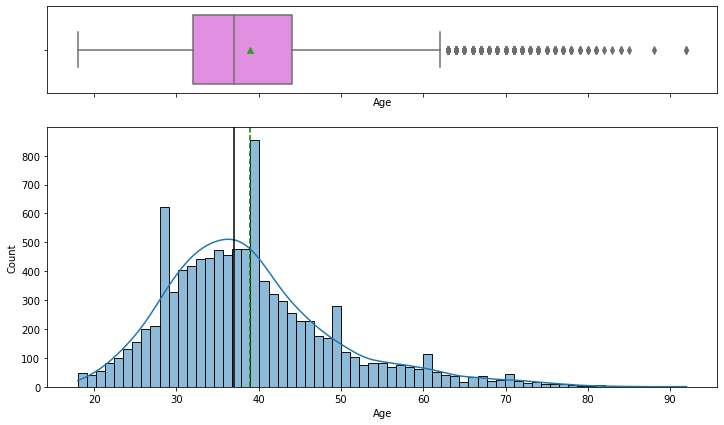

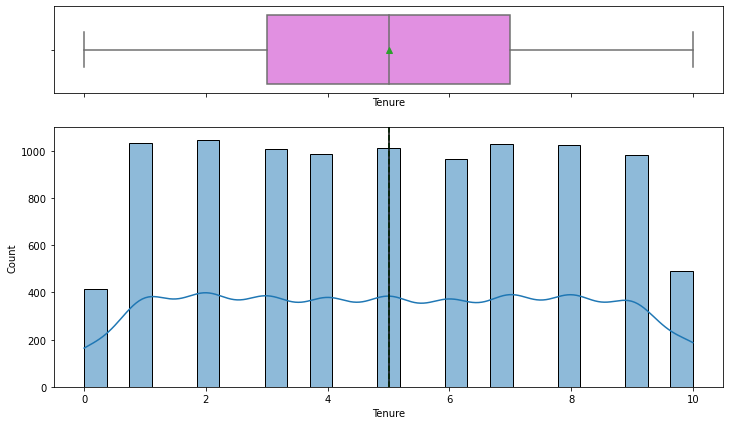

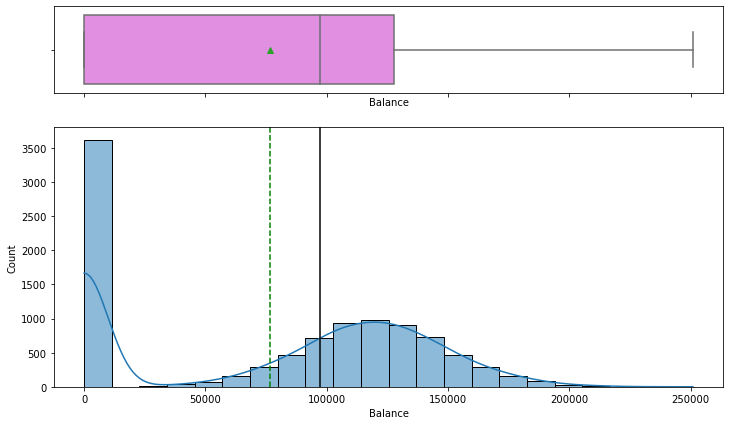

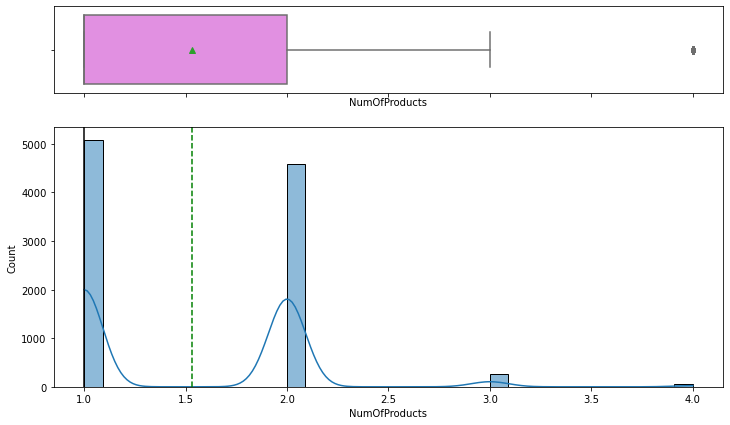

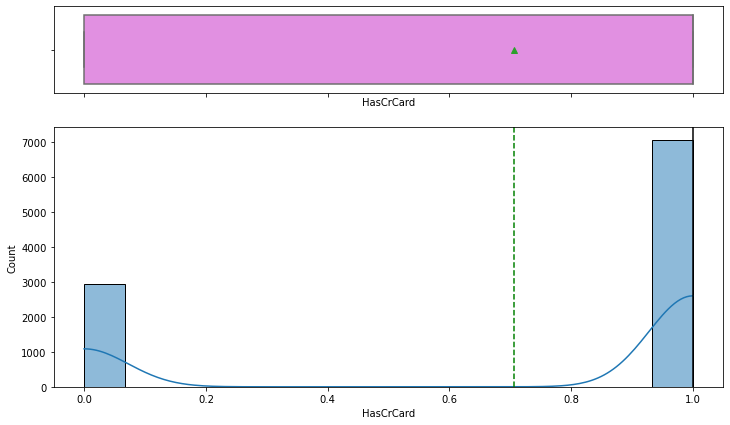

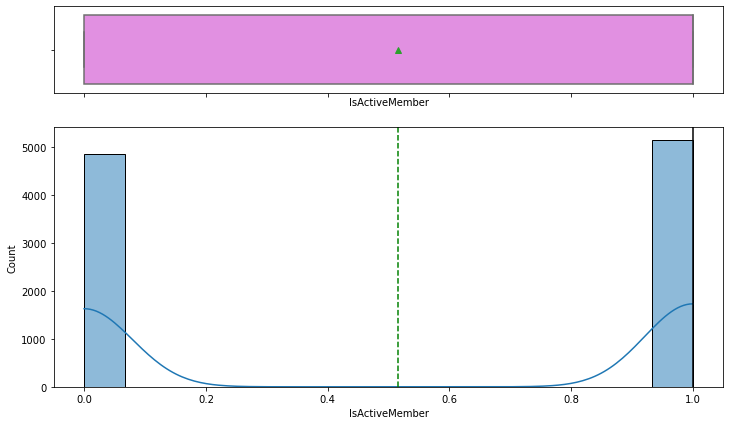

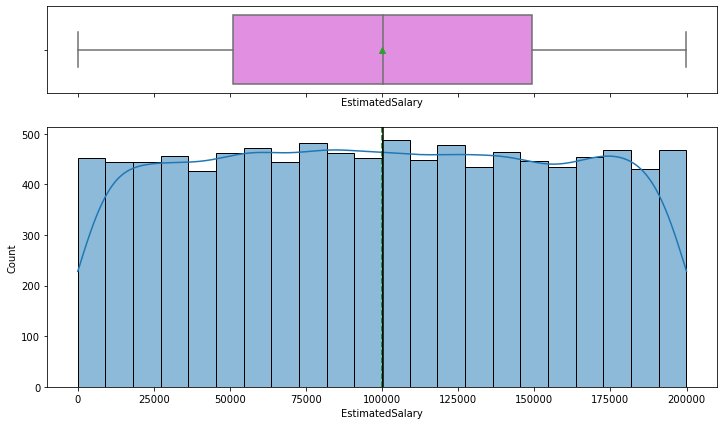

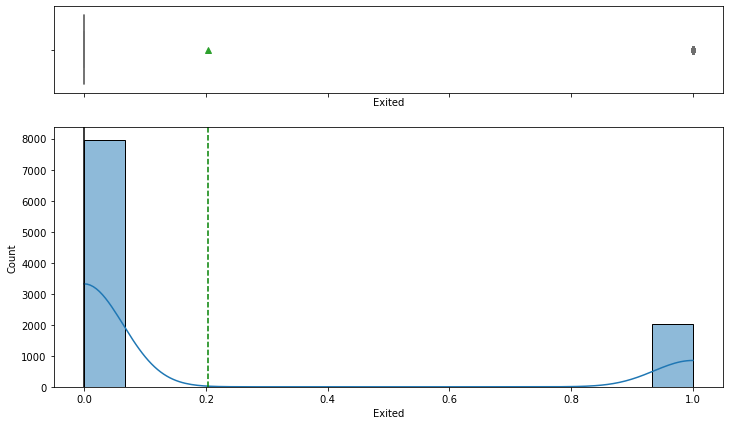

<IPython.core.display.Javascript object>

In [47]:
for col in numcols:
    histogram_boxplot(data, col,kde=True)


Observations:
* CreditScore looks almost normalized with some outliers.
* Age is right skewed with outliers.
* No outliers seen in Tenure, Balance, HasCrCard, IsActiveMember, and EstimatedSalary.
* A few outliers are seen in NumOfProducts and Exited.

### Create bar plots for the numerical features

Create new subset

In [48]:
numcols2 = ['CreditScore_Groups','Age_Groups','Tenure','Balance_Groups','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary_Groups','Exited']

<IPython.core.display.Javascript object>

Create a temporary dataframe

In [49]:
df = data.copy()

<IPython.core.display.Javascript object>

Bin some of the numerical features for visualization.

In [50]:
df["CreditScore_Groups"] = pd.cut(x=data["CreditScore"],bins=[340, 640, 720, 1000],labels=["Low", "Middle", "High"])

<IPython.core.display.Javascript object>

In [51]:
df["Age_Groups"] = pd.cut(x=data["Age"],bins=[17, 35, 70, 100],labels=["Low", "Middle", "High"])

<IPython.core.display.Javascript object>

In [52]:
df["Balance_Groups"] = pd.cut(x=data["Balance"],bins=[-1, 25000, 75000, 260000],labels=["Low", "Middle", "High"])

<IPython.core.display.Javascript object>

In [53]:
df["EstimatedSalary_Groups"] = pd.cut(x=data["EstimatedSalary"],bins=[0, 50000, 100000, 200000],labels=["Low", "Middle", "High"])

<IPython.core.display.Javascript object>

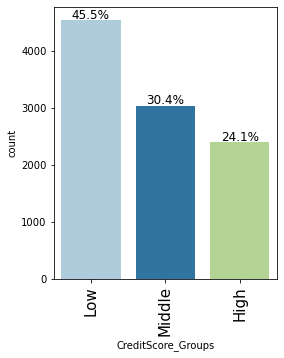

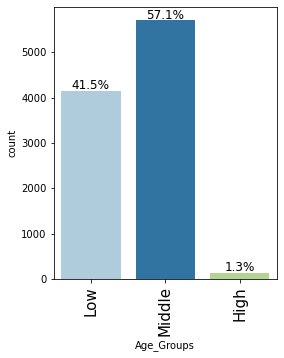

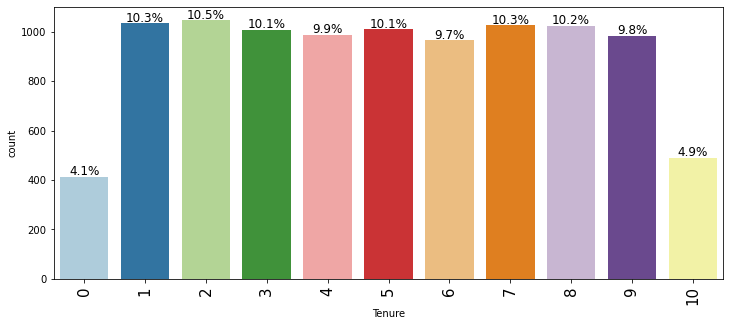

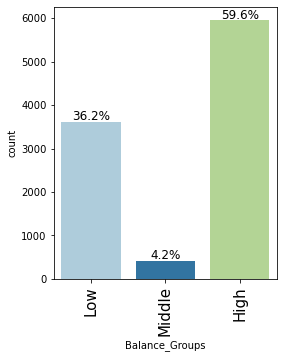

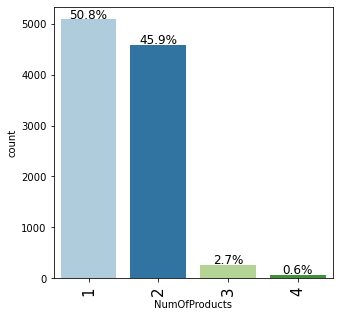

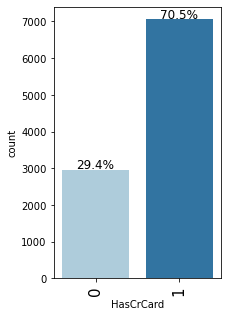

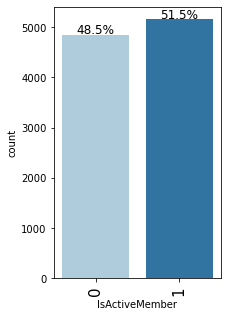

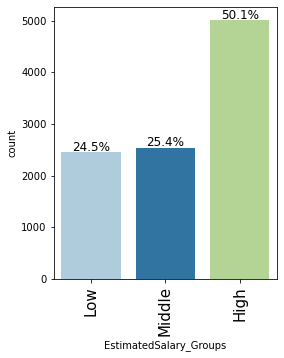

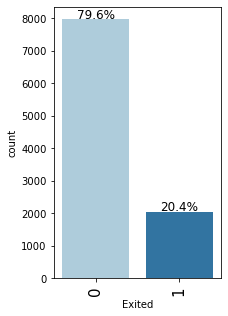

<IPython.core.display.Javascript object>

In [54]:
for col in numcols2:
    labeled_barplot(df,col,perc=True)    

Observations:

* About 45% of customers have a low to fair credit score.
* Over 75% of customers are between the ages of 18 to 70.
* Tenure is spread out somewhat evenly, except for years 0 and 10.
* Almost 60% of customers maintain a high account balance.
* The vast majority of customers purchased just one or two products through the bank.
* 70% of customers have a credit card.
* Just over 50% are active customers.
* 50% of customers have high estimated salaries.
* About 20% of customers have left the bank.


### Create bar plots for the categorical features

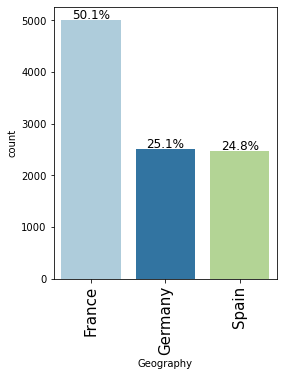

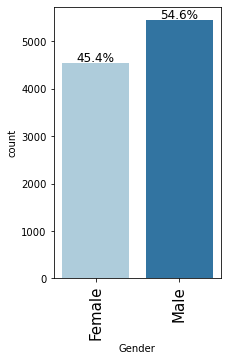

<IPython.core.display.Javascript object>

In [55]:
for col in catcols:
    labeled_barplot(df,col,perc=True)   

Observations:

* 50% of customers are from France.  A little over 25% are from Germany and almost 25% are from Spain.
* About 55% of customers are male and about 45% are female.

0    7963
1    2037
Name: Exited, dtype: int64


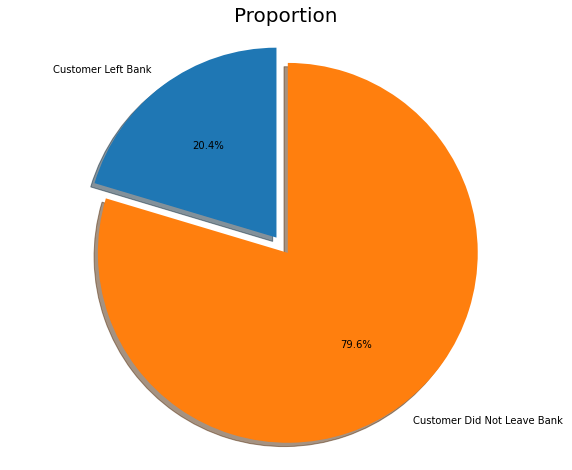

<IPython.core.display.Javascript object>

In [56]:
print(data.Exited.value_counts())
labels = 'Customer Left Bank', 'Customer Did Not Leave Bank'
sizes = [data.Exited[data['Exited']==1].count(),data.Exited[data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion", size = 20)
plt.show()

* The pie chart shows that the distribution of classes is imbalanced for the Exited (target) variable.
* Only ~20% of customers left the bank in this dataset.

We have an imbalanced classification problem that we will have to deal with.

## Bivariate Analysis

In [57]:
subsetcols = ['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']

<IPython.core.display.Javascript object>

View distribution plot with regard to the target variable -> Exited.

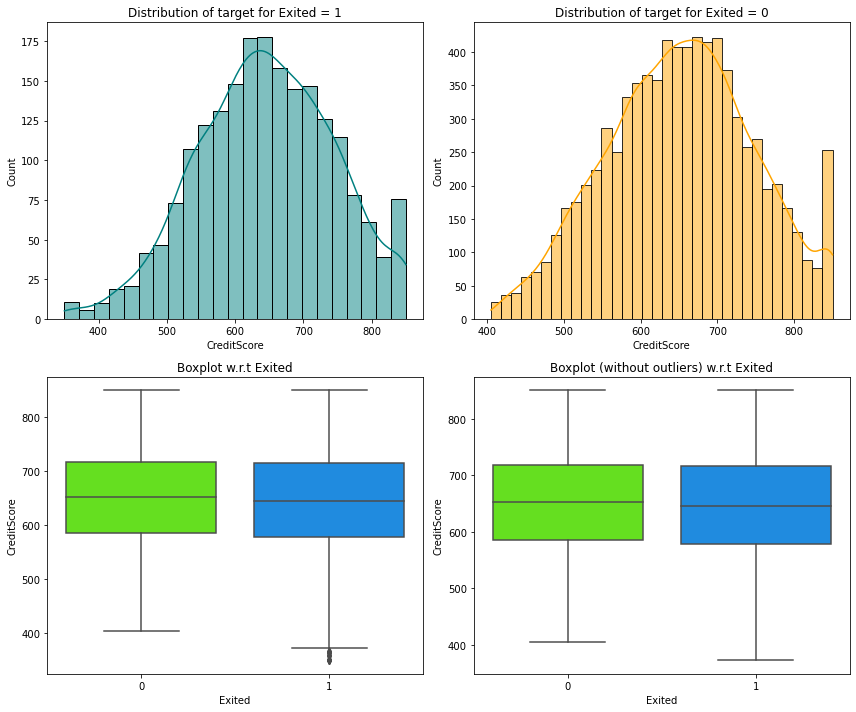

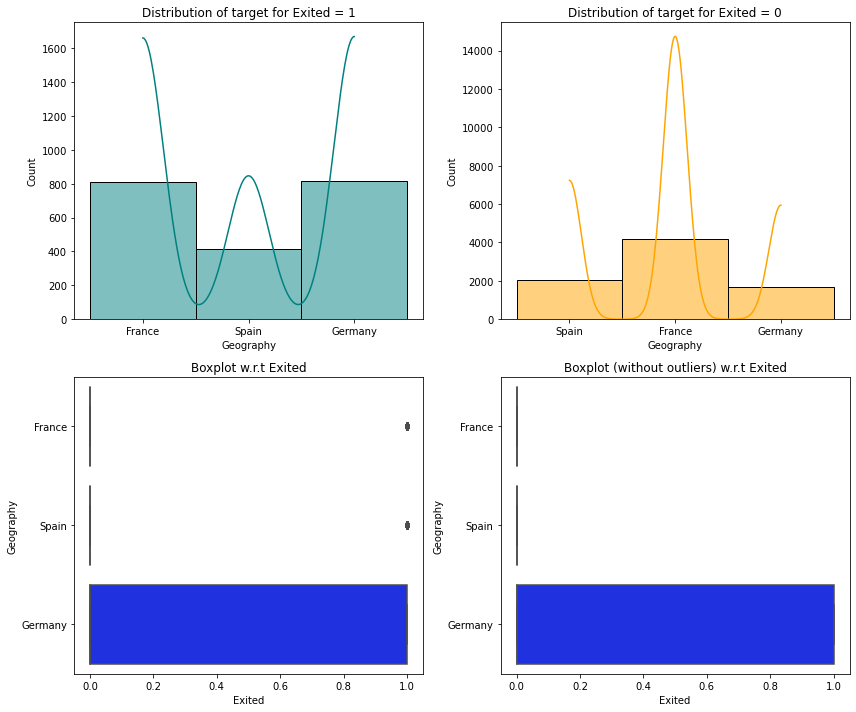

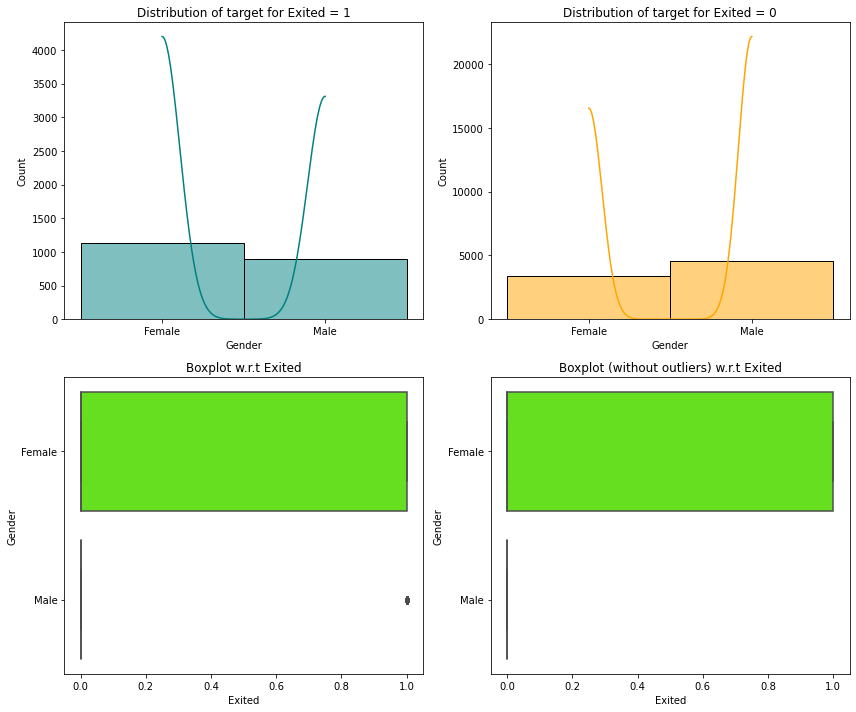

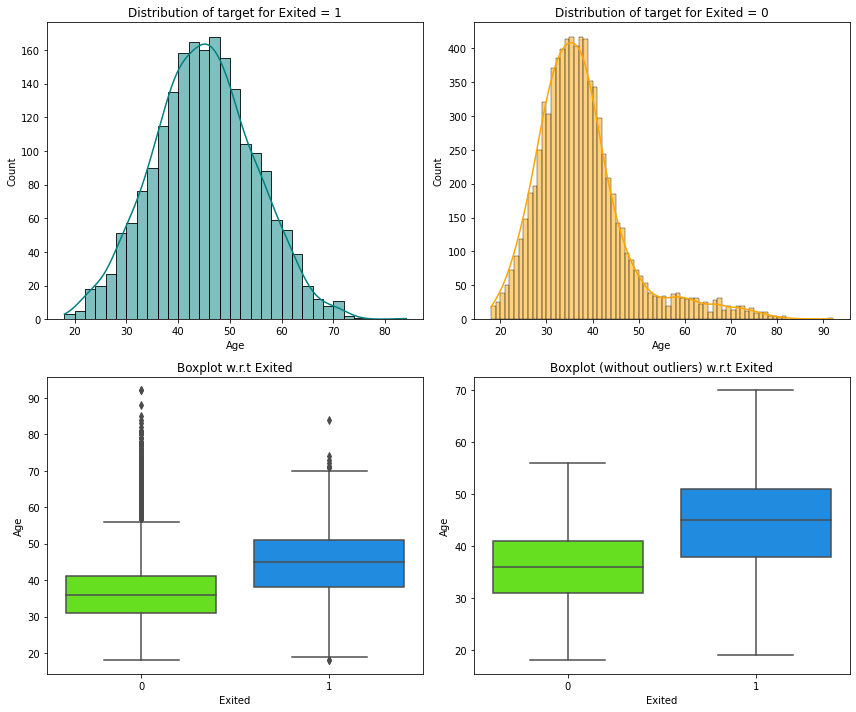

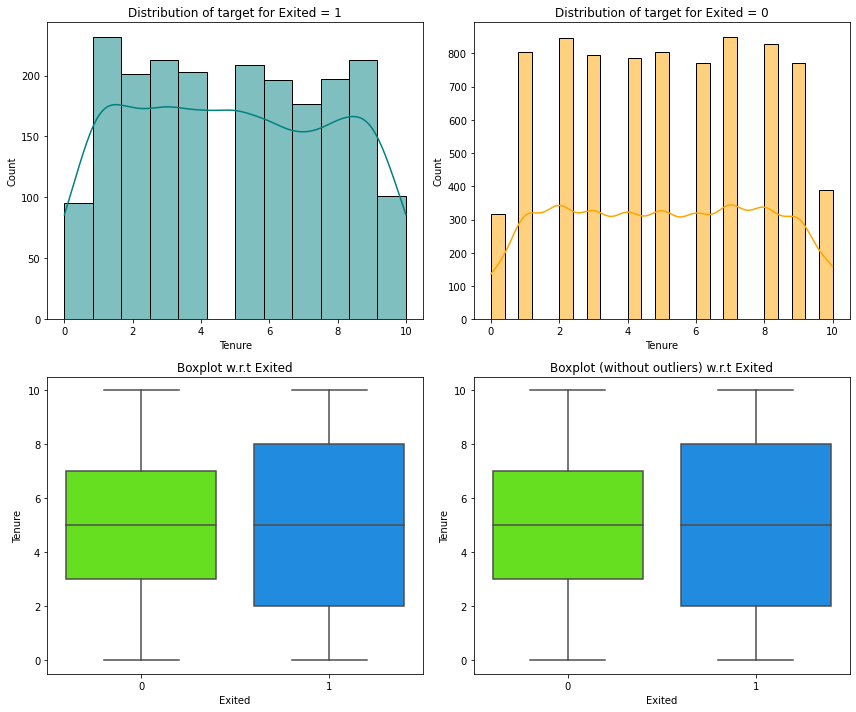

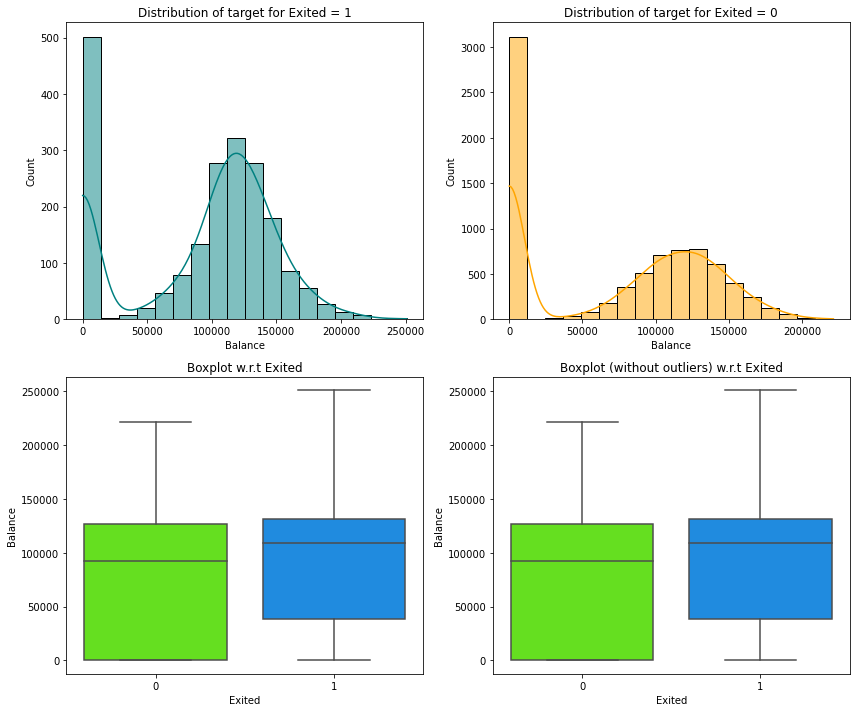

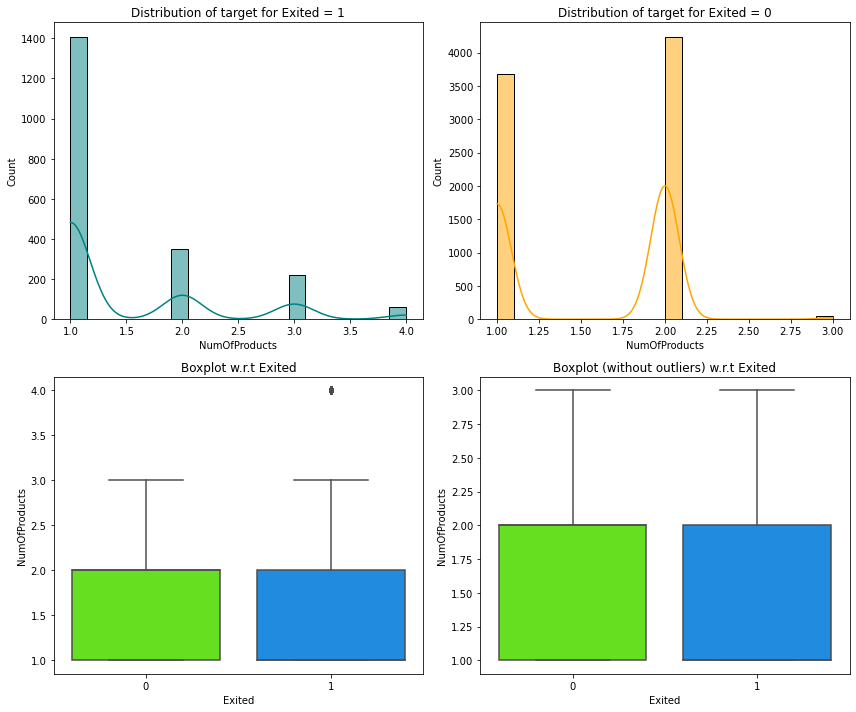

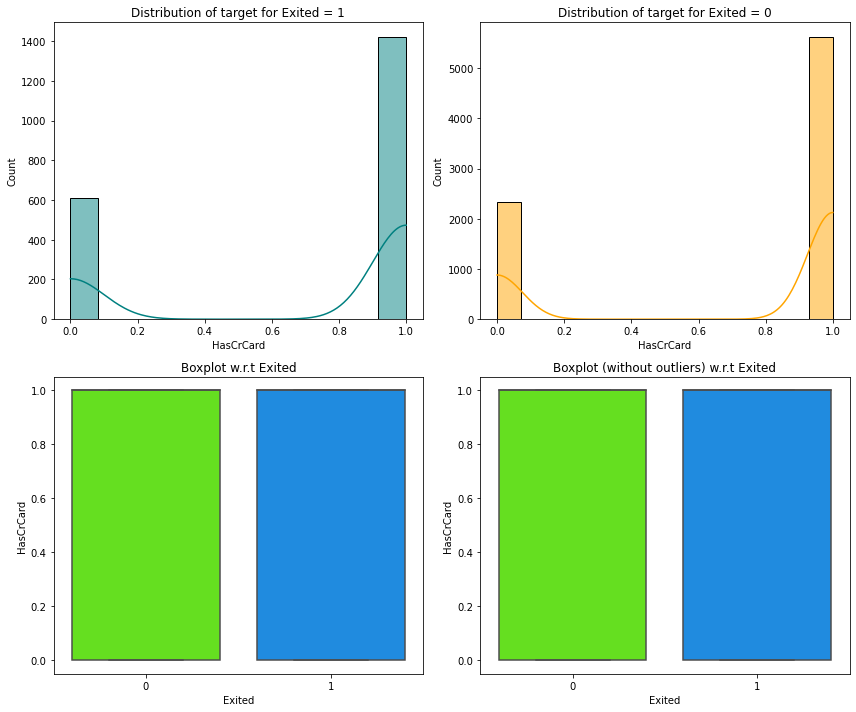

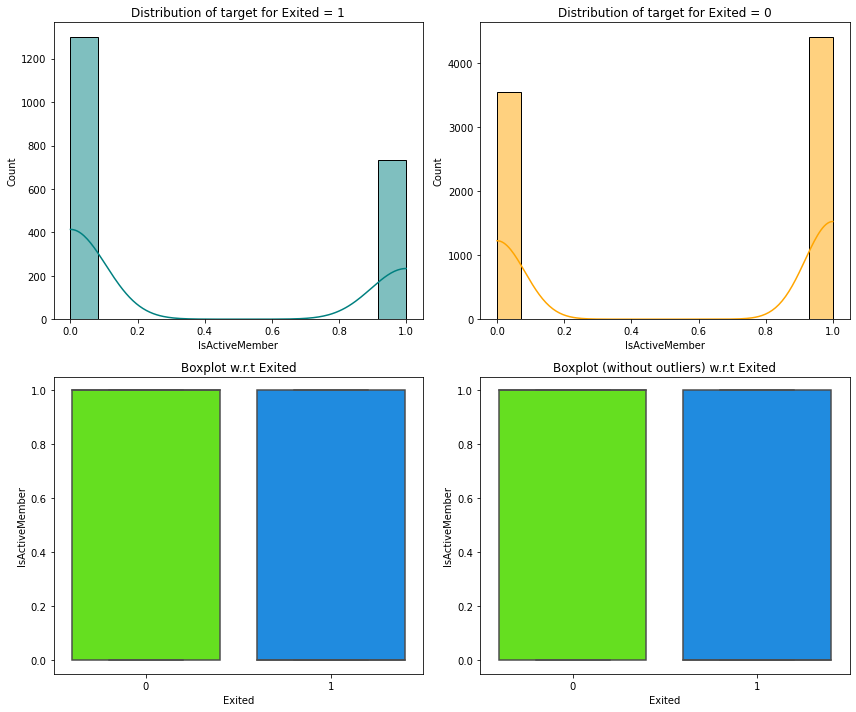

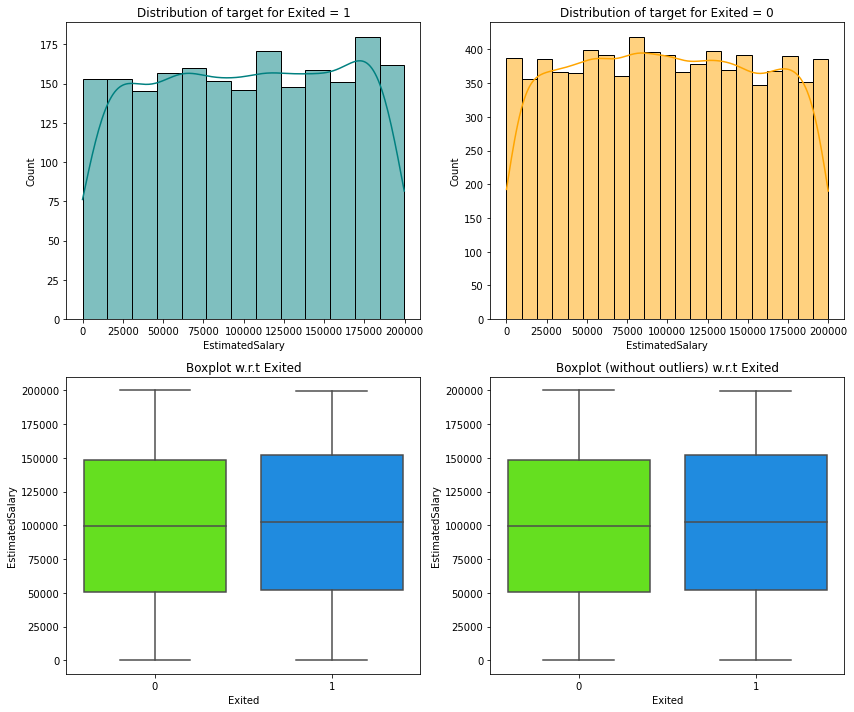

<IPython.core.display.Javascript object>

In [58]:
for col in subsetcols:
    distribution_plot_wrt_target(data, col, "Exited")

Observations:

* Average credit score is about 650 for both active and inactive customers.
* More customers from France and Germany have left the bank as compared to Spain.
* Slightly more female have left the bank compared to males.
* The average age of customers who left the bank appears to be about 45.
* 50% of exited customers have tenure between about 2 to 8 years.
* Account balances look almost normalized except for a low value spike.
* Number of products appear equal between active and inactive customers.
* Estimated salaries look similar between active and inactive customers.


View data using stacked barplot

In [59]:
numcols3 = ['CreditScore_Groups','Age_Groups','Tenure','Balance_Groups','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary_Groups']

<IPython.core.display.Javascript object>

Exited                 0     1    All
CreditScore_Groups                   
All                 7963  2037  10000
Low                 3575   975   4550
Middle              2466   576   3042
High                1922   486   2408
------------------------------------------------------------------------------------------------------------------------


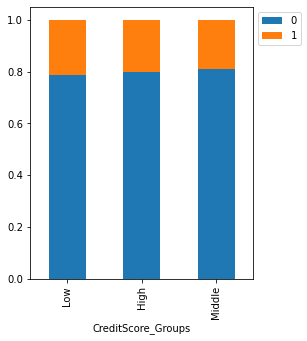

Exited         0     1    All
Age_Groups                   
All         7963  2037  10000
Middle      4035  1679   5714
Low         3806   347   4153
High         122    11    133
------------------------------------------------------------------------------------------------------------------------


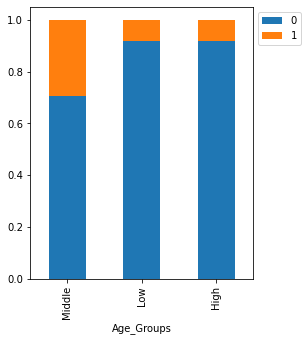

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


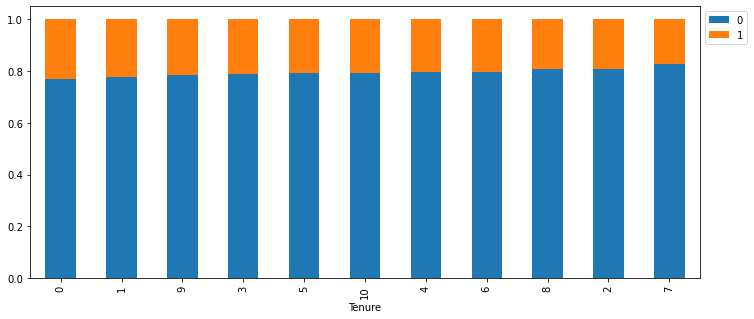

Exited             0     1    All
Balance_Groups                   
All             7963  2037  10000
High            4523  1436   5959
Low             3119   504   3623
Middle           321    97    418
------------------------------------------------------------------------------------------------------------------------


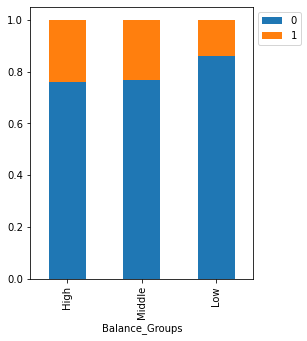

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


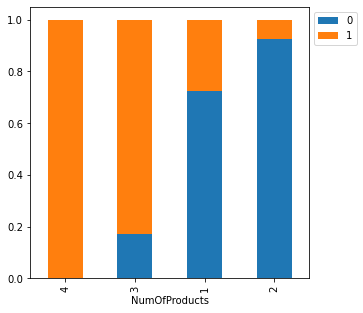

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


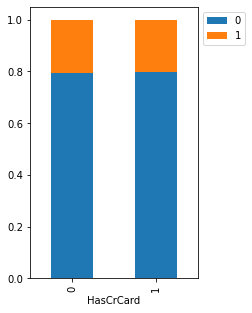

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


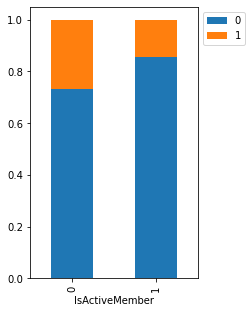

Exited                     0     1    All
EstimatedSalary_Groups                   
All                     7963  2037  10000
High                    3966  1044   5010
Middle                  2033   504   2537
Low                     1964   489   2453
------------------------------------------------------------------------------------------------------------------------


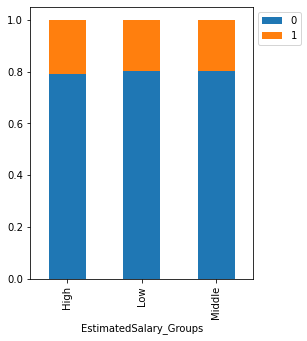

<IPython.core.display.Javascript object>

In [60]:
for col in numcols3:
    stacked_barplot(df, col, "Exited")

Observations:

* 76% of inactive customers are found in the low and middle credit score groups.
* Almost all inactive customers are found in the low and middle age groups.
* The tenure for inactive customers is spread out evenly for the most part.
* 70% of inactive customers had a high account balance compared to about 57% of active customers.
* The majority of both inactive and active customers purchased 1 to 2 products from the bank.
* 70% of both inactive and active customers had a credit card.
* 20% of customers have left the bank.
* 76% of inactive customers have middle to high estimated salaries.

### Check for correlations between the features.

In [61]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


<IPython.core.display.Javascript object>

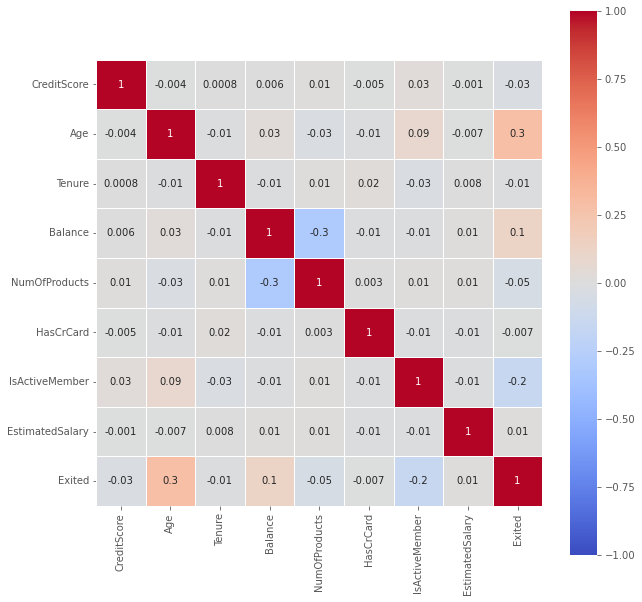

<IPython.core.display.Javascript object>

In [62]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 10))
g = sns.heatmap(data.corr(), annot=True,vmin=-1,vmax=1,fmt='.1g',cmap='coolwarm', square=True, linecolor='w', linewidth=.5)
plt.show()

There is not much positive correlation between features. There is a low correlation betweeen Age and Exited. 

In [63]:
sns.pairplot(data,diag_kind='kde',vars=numcols)

<IPython.core.display.Javascript object>

# Outlier Analysis & Treatment

Call the function that provides outlier statistics

In [64]:
exceptions = 0
for col in data.columns:
    try:
        get_outliers(data,col)
    except:
        exceptions = exceptions +1
        #print('Exception thrown for ',col)
    print(' ')

CreditScore
mean=650.529 stdv=96.648
Percentiles: 25th=584.00, 75th=718.00, 100th=850.00, IQR=134.00
Outliers = 15
 
Geography
 
Gender
 
Age
mean=38.922 stdv=10.487
Percentiles: 25th=32.00, 75th=44.00, 100th=92.00, IQR=12.00
Outliers = 359
 
Tenure
mean=5.013 stdv=2.892
Percentiles: 25th=3.00, 75th=7.00, 100th=10.00, IQR=4.00
Outliers = 0
 
Balance
mean=76485.889 stdv=62394.285
Percentiles: 25th=0.00, 75th=127644.24, 100th=250898.09, IQR=127644.24
Outliers = 0
 
NumOfProducts
mean=1.530 stdv=0.582
Percentiles: 25th=1.00, 75th=2.00, 100th=4.00, IQR=1.00
Outliers = 60
 
HasCrCard
mean=0.706 stdv=0.456
Percentiles: 25th=0.00, 75th=1.00, 100th=1.00, IQR=1.00
Outliers = 0
 
IsActiveMember
mean=0.515 stdv=0.500
Percentiles: 25th=0.00, 75th=1.00, 100th=1.00, IQR=1.00
Outliers = 0
 
EstimatedSalary
mean=100090.240 stdv=57507.617
Percentiles: 25th=51002.11, 75th=149388.25, 100th=199992.48, IQR=98386.14
Outliers = 0
 
Exited
mean=0.204 stdv=0.403
Percentiles: 25th=0.00, 75th=0.00, 100th=1.00, I

<IPython.core.display.Javascript object>

Call the function that treats the outliers

In [65]:
exceptions = 0
for col in numcols:
    try:
        treat_outliers(data,col)
    except:
        exceptions = exceptions +1
       #print('Exception thrown for ',col)
    print(' ')

<IPython.core.display.Javascript object>

Verify outliers have been treated.

In [66]:
exceptions = 0
for col in data.columns:
    try:
        get_outliers(data,col)
    except:
        exceptions = exceptions +1
        #print('Exception thrown for ',col)
    print(' ')

CreditScore
mean=650.529 stdv=96.648
Percentiles: 25th=584.00, 75th=718.00, 100th=850.00, IQR=134.00
Outliers = 15
 
Geography
 
Gender
 
Age
mean=38.922 stdv=10.487
Percentiles: 25th=32.00, 75th=44.00, 100th=92.00, IQR=12.00
Outliers = 359
 
Tenure
mean=5.013 stdv=2.892
Percentiles: 25th=3.00, 75th=7.00, 100th=10.00, IQR=4.00
Outliers = 0
 
Balance
mean=76485.889 stdv=62394.285
Percentiles: 25th=0.00, 75th=127644.24, 100th=250898.09, IQR=127644.24
Outliers = 0
 
NumOfProducts
mean=1.530 stdv=0.582
Percentiles: 25th=1.00, 75th=2.00, 100th=4.00, IQR=1.00
Outliers = 60
 
HasCrCard
mean=0.706 stdv=0.456
Percentiles: 25th=0.00, 75th=1.00, 100th=1.00, IQR=1.00
Outliers = 0
 
IsActiveMember
mean=0.515 stdv=0.500
Percentiles: 25th=0.00, 75th=1.00, 100th=1.00, IQR=1.00
Outliers = 0
 
EstimatedSalary
mean=100090.240 stdv=57507.617
Percentiles: 25th=51002.11, 75th=149388.25, 100th=199992.48, IQR=98386.14
Outliers = 0
 
Exited
mean=0.204 stdv=0.403
Percentiles: 25th=0.00, 75th=0.00, 100th=1.00, I

<IPython.core.display.Javascript object>

Copy the data frame

In [67]:
data2=data.copy()

<IPython.core.display.Javascript object>

Verify all looks normal.

In [68]:
data2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<IPython.core.display.Javascript object>

In [69]:
data2['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<IPython.core.display.Javascript object>

Target variable is imbalanced.

### Separating Independent and Dependent Features

In [70]:

X = data2.drop(['Exited'],axis=1)
Y = data2[['Exited']]

<IPython.core.display.Javascript object>

### Encoding Categorical Columns

We will use the label encoder against the categorical features of the dataset.

* For the Geograpy feature, 0 = France, 1 = Germany , 2 = Spain. 
* For the Gender feature 0 = Female, 1 = Male

In [71]:
labelencoder = LabelEncoder()
X['Geography']= labelencoder.fit_transform(X['Geography'])

<IPython.core.display.Javascript object>

In [72]:
X['Gender']= labelencoder.fit_transform(X['Gender'])

<IPython.core.display.Javascript object>

Verify encoding was successful.

In [73]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


<IPython.core.display.Javascript object>

Split the dataset into the training and test sets.  Since the target variable data is imbalanced, we will use the stratify function in the train test split.


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1,stratify=Y)

<IPython.core.display.Javascript object>

Scale the dataset before model building

In [75]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

Checking the shape of train and test data

In [76]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 10)
(2000, 10)
(8000, 1)
(2000, 1)


<IPython.core.display.Javascript object>

# Model Building

#### **A model can make wrong predictions in the following ways:**
* Predicting a customer will leave the bank but does not.
* Predicting a customer will not leave the bank but does leave.

#### **Which case is more important?**

Both scenarios are important but predicting a customer will not leave the bank but does is most important as this will lead to a loss of profits.
Predicting a customer will leave the bank but does not is also meaningful because the bank will waste resources on trying to keep a customer that has no plans on leaving.

#### **How to reduce False Negatives as well as False Positives?**

Since both errors are important for us to minimize, the bank will want to focus on the F1 Score.

## Create an inital model and get the performance results.

# Model 1

In [77]:
# Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.
backend.clear_session()
# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

In [78]:
# Initializing the ANN
model1 = Sequential()
model1.add(Dense(activation = 'relu', input_dim = X_train.shape[1], units=64))
#Add 1st hidden layer
model1.add(Dense(32, activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
model1.add(Dense(1, activation = 'sigmoid'))

<IPython.core.display.Javascript object>

In [79]:
# Create optimizer with default learning rate
# Compile the model
model1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [80]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [81]:
history_1=model1.fit(X_train, y_train,validation_split=0.2,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.5437 - accuracy: 0.7698 - val_loss: 0.4978 - val_accuracy: 0.7906
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.7977 - val_loss: 0.4745 - val_accuracy: 0.7906
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.7977 - val_loss: 0.4583 - val_accuracy: 0.7912
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4456 - accuracy: 0.8002 - val_loss: 0.4465 - val_accuracy: 0.7937
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4354 - accuracy: 0.8053 - val_loss: 0.4369 - val_accuracy: 0.7987
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4273 - accuracy: 0.8108 - val_loss: 0.4292 - val_accuracy: 0.8087
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8152 - val_loss: 0.4233 - val_accuracy: 0.8150
Epoch 

<IPython.core.display.Javascript object>

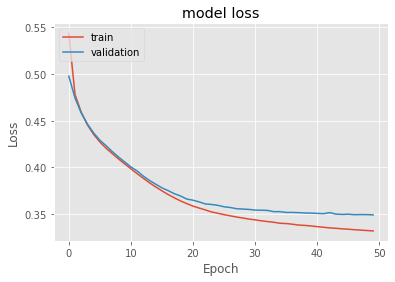

63/63 [==============================] - 0s 1ms/step - loss: 0.3586 - accuracy: 0.8600


<IPython.core.display.Javascript object>

In [82]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = model1.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.204626, G-Mean=0.754


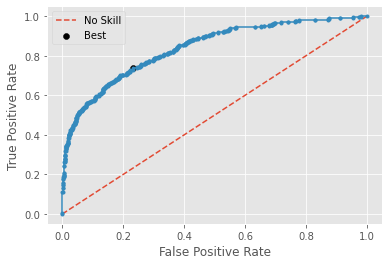

<IPython.core.display.Javascript object>

In [83]:
# predict probabilities
yhat1 = model1.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

We use the threshold calculated above.

In [84]:
y_pred=model1.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

<IPython.core.display.Javascript object>

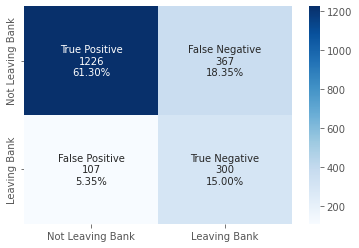

<IPython.core.display.Javascript object>

In [85]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [86]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.45      0.74      0.56       407

    accuracy                           0.76      2000
   macro avg       0.68      0.75      0.70      2000
weighted avg       0.82      0.76      0.78      2000



<IPython.core.display.Javascript object>

In [87]:
save_classification_report(cr,'Model 1')

<IPython.core.display.Javascript object>

In [88]:
print(classification_reports)

[     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76]


<IPython.core.display.Javascript object>

F1 score for class 0 is good, but not great for class 1 (customer left the bank).  Precision here is low.

## Model 2

Create a 2nd model.  This time we will change the optimizer from 'SGD' to Adam.

In [89]:
backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

In [90]:
# Initializing the ANN
model2 = Sequential()
model2.add(Dense(activation = 'relu', input_dim = X_train.shape[1], units=64))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation = 'sigmoid'))

<IPython.core.display.Javascript object>

In [91]:
#Compiling the ANN with Adam optimizer and binary cross entropy loss function 
optimizer = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [92]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [93]:
history_2=model2.fit(X_train, y_train,validation_split=0.2,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
200/200 [==============================] - 2s 5ms/step - loss: 0.4576 - accuracy: 0.8022 - val_loss: 0.4087 - val_accuracy: 0.8350
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3882 - accuracy: 0.8388 - val_loss: 0.3685 - val_accuracy: 0.8550
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3612 - accuracy: 0.8514 - val_loss: 0.3615 - val_accuracy: 0.8450
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3500 - accuracy: 0.8541 - val_loss: 0.3519 - val_accuracy: 0.8550
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3443 - accuracy: 0.8566 - val_loss: 0.3484 - val_accuracy: 0.8581
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3399 - accuracy: 0.8570 - val_loss: 0.3473 - val_accuracy: 0.8550
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3356 - accuracy: 0.8612 - val_loss: 0.3526 - val_accuracy: 0.8544
Epoch 

<IPython.core.display.Javascript object>

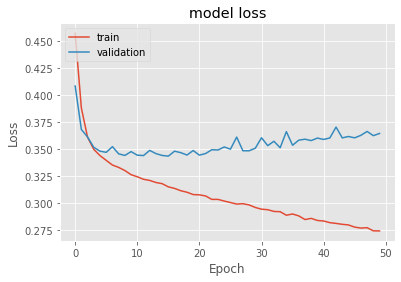

63/63 [==============================] - 0s 3ms/step - loss: 0.3676 - accuracy: 0.8570


<IPython.core.display.Javascript object>

In [94]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = model2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.207772, G-Mean=0.768


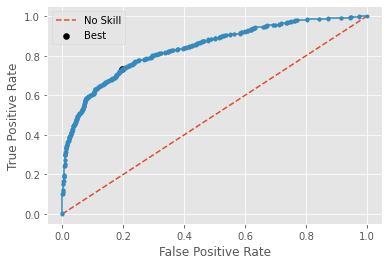

<IPython.core.display.Javascript object>

In [95]:
# predict probabilities
yhat1 = model2.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [96]:
y_pred=model2.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 3ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

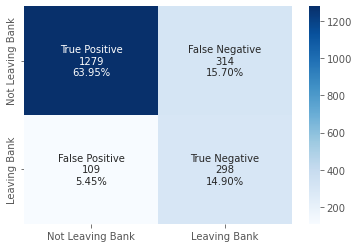

<IPython.core.display.Javascript object>

In [97]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [98]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.49      0.73      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.79      0.80      2000



<IPython.core.display.Javascript object>

In [99]:
save_classification_report(cr,'Model 2')

<IPython.core.display.Javascript object>

In [100]:
for r in classification_reports:
    print(r)

     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76
     model   class precision recall f1_score support accuracy
0  Model 2       0      0.92    0.8     0.86  1593.0         
1  Model 2       1      0.49   0.73     0.58   407.0         
2                                                        0.79


<IPython.core.display.Javascript object>

Model 2 accuracy and F1 scores increased slightly.

## Model 3

In [101]:
backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

We will add more hidden layers and use Dropout.

In [102]:

def create_model_v3(lr,batch_size):  
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

<IPython.core.display.Javascript object>

In [103]:
keras_estimator = KerasClassifier(build_fn=create_model_v3, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_distributions=param_random,n_jobs=-1)

<IPython.core.display.Javascript object>

In [104]:
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
100/100 [==============================] - 2s 9ms/step - loss: 0.4398 - accuracy: 0.8159 - val_loss: 0.3725 - val_accuracy: 0.8506
Best: 0.840000 using {'lr': 0.01, 'batch_size': 64}


<IPython.core.display.Javascript object>

RandomSearchCV produced the following configuration: 

{'batch_size': 64, 'learning_rate": 0.01}

We will use these paramters to build model 3.

In [105]:
estimator_v3=create_model_v3(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])

estimator_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

<IPython.core.display.Javascript object>

In [106]:
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator_v3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_3=estimator_v3.fit(X_train, y_train, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 2s 7ms/step - loss: 0.4437 - accuracy: 0.8141 - val_loss: 0.3890 - val_accuracy: 0.8481
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3886 - accuracy: 0.8398 - val_loss: 0.3606 - val_accuracy: 0.8550
Epoch 3/50
100/100 [==============================] - 0s 5ms/step - loss: 0.3787 - accuracy: 0.8403 - val_loss: 0.3677 - val_accuracy: 0.8438
Epoch 4/50
100/100 [==============================] - 0s 5ms/step - loss: 0.3686 - accuracy: 0.8484 - val_loss: 0.3540 - val_accuracy: 0.8600
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3673 - accuracy: 0.8492 - val_loss: 0.3529 - val_accuracy: 0.8606
Epoch 6/50
100/100 [==============================] - 0s 5ms/step - loss: 0.3643 - accuracy: 0.8489 - val_loss: 0.3763 - val_accuracy: 0.8606
Epoch 7/50
100/100 [==============================] - 0s 5ms/step - loss: 0.3628 - accuracy: 0.8531 - val_loss: 0.3618 - val_accuracy: 0.8419
Epoch 

<IPython.core.display.Javascript object>

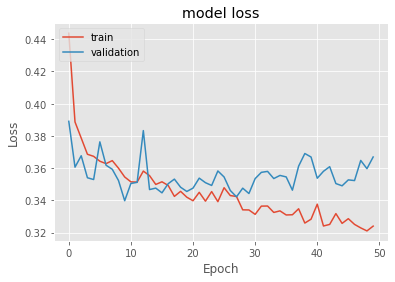

63/63 [==============================] - 0s 3ms/step - loss: 0.3571 - accuracy: 0.8585


<IPython.core.display.Javascript object>

In [107]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = estimator_v3.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step
Best Threshold=0.185797, G-Mean=0.772


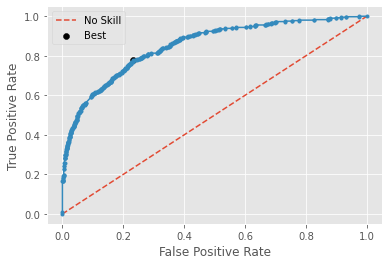

<IPython.core.display.Javascript object>

In [108]:
# predict probabilities
yhat1 = estimator_v3.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [109]:
y_pred=estimator_v3.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

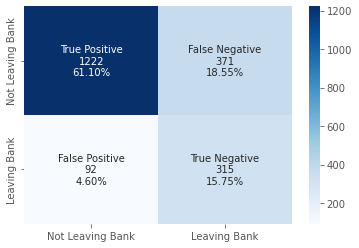

<IPython.core.display.Javascript object>

In [110]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [111]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1593
           1       0.46      0.77      0.58       407

    accuracy                           0.77      2000
   macro avg       0.69      0.77      0.71      2000
weighted avg       0.83      0.77      0.79      2000



<IPython.core.display.Javascript object>

In [112]:
save_classification_report(cr,'Model 3')

<IPython.core.display.Javascript object>

In [113]:
for r in classification_reports:
    print(r)

     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76
     model   class precision recall f1_score support accuracy
0  Model 2       0      0.92    0.8     0.86  1593.0         
1  Model 2       1      0.49   0.73     0.58   407.0         
2                                                        0.79
     model   class precision recall f1_score support accuracy
0  Model 3       0      0.93   0.77     0.84  1593.0         
1  Model 3       1      0.46   0.77     0.58   407.0         
2                                                        0.77


<IPython.core.display.Javascript object>

Not much change is seen so far between the models.

## Model 4

We will try GridSearchCV next.

In [114]:
backend.clear_session()
np.random.seed(1)
#random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

In [115]:
def create_model_v4(lr,batch_size):  
    # Initializing the ANN
    model4 = Sequential()
    model4.add(Dense(activation = 'relu', input_dim = X_train.shape[1], units=64))
    model4.add(Dense(32, activation='relu'))
    model4.add(Dense(1, activation = 'sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model4.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model4

<IPython.core.display.Javascript object>

In [116]:
keras_estimator = KerasClassifier(build_fn=create_model_v4, verbose=1)
# define the grid search parameters
param_grid = {
    'batch_size':[32,64,128],
    "lr":[0.01,0.1,0.001],
    'epochs':[50,100]}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1)

<IPython.core.display.Javascript object>

In [117]:
# store starting time
begin = time.time()

grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime of the program is {end - begin}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/50
50/50 [==============================] - 1s 8ms/step - loss: 0.5240 - accuracy: 0.7722 - val_loss: 0.4664 - val_accuracy: 0.7906
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4377 - accuracy: 0.8066 - val_loss: 0.4253 - val_accuracy: 0.8150
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.8234 - val_loss: 0.4041 - val_accuracy: 0.8344
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3924 - accuracy: 0.8402 - val_loss: 0.3860 - val_accuracy: 0.8475
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3748 - accuracy: 0.8467 - val_loss: 0.3704 - val_accuracy: 0.8556
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3625 - accuracy: 0.8512 - val_loss: 0.3603 - val_accuracy: 0.8544
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3527 - accuracy: 0.8558 -

<IPython.core.display.Javascript object>

In [118]:
estimator_v4=create_model_v4(batch_size=grid_result.best_params_['batch_size'],lr=grid_result.best_params_['lr'])

estimator_v4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [119]:
optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
estimator_v4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_4=estimator_v4.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], batch_size = grid_result.best_params_['batch_size'], verbose=1,validation_split=0.2)

Epoch 1/50
50/50 [==============================] - 1s 9ms/step - loss: 0.4986 - accuracy: 0.7894 - val_loss: 0.4552 - val_accuracy: 0.7906
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4362 - accuracy: 0.8064 - val_loss: 0.4303 - val_accuracy: 0.8131
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4166 - accuracy: 0.8208 - val_loss: 0.4140 - val_accuracy: 0.8338
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4008 - accuracy: 0.8331 - val_loss: 0.3964 - val_accuracy: 0.8413
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3834 - accuracy: 0.8431 - val_loss: 0.3790 - val_accuracy: 0.8438
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3688 - accuracy: 0.8475 - val_loss: 0.3653 - val_accuracy: 0.8481
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3566 - accuracy: 0.8508 - val_loss: 0.3589 - val_accuracy: 0.8519
Epoch 8/50
50/50 [==

<IPython.core.display.Javascript object>

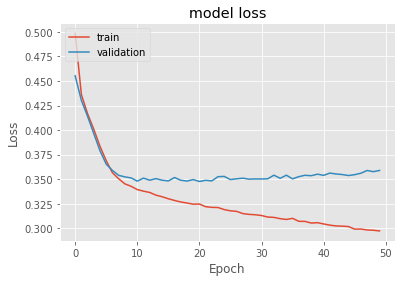

63/63 [==============================] - 0s 2ms/step - loss: 0.3581 - accuracy: 0.8535


<IPython.core.display.Javascript object>

In [120]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = estimator_v4.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.205557, G-Mean=0.758


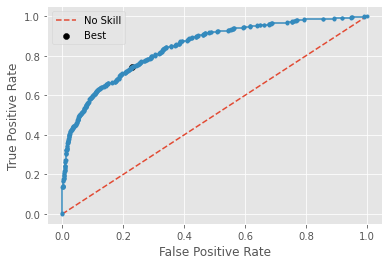

<IPython.core.display.Javascript object>

In [121]:
# predict probabilities
yhat1 = estimator_v4.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [122]:
y_pred=estimator_v4.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

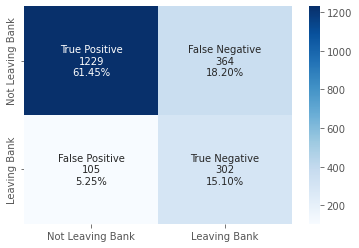

<IPython.core.display.Javascript object>

In [123]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [124]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.45      0.74      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.76      0.70      2000
weighted avg       0.83      0.77      0.78      2000



<IPython.core.display.Javascript object>

In [125]:
save_classification_report(cr,'Model 4')

<IPython.core.display.Javascript object>

In [126]:
for r in classification_reports:
    print(r)

     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76
     model   class precision recall f1_score support accuracy
0  Model 2       0      0.92    0.8     0.86  1593.0         
1  Model 2       1      0.49   0.73     0.58   407.0         
2                                                        0.79
     model   class precision recall f1_score support accuracy
0  Model 3       0      0.93   0.77     0.84  1593.0         
1  Model 3       1      0.46   0.77     0.58   407.0         
2                                                        0.77
     model   class precision recall f1_score support accuracy
0  Model 4       0      0.92   0.77     0.84  1593.0         
1  Model 4       1      0.45   0.74     0.56   407.0         
2                                                        0.77


<IPython.core.display.Javascript object>

Still not seeing a lot of improvment from model to model.

## Model 5

Try to use  SMOTE to balance the dataset and try again with the GridSearchCV.

In [127]:
backend.clear_session()
np.random.seed(1)
#random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

In [128]:
smote=SMOTE(sampling_strategy='not majority')
X_sm , y_sm = smote.fit_resample(X_train,y_train)

<IPython.core.display.Javascript object>

In [129]:
def create_model_v5(lr,batch_size):  
    # Initializing the ANN
    model5 = Sequential()
    model5.add(Dense(activation = 'relu', input_dim = X_sm.shape[1], units=64))
    model5.add(Dense(32, activation='relu'))
    model5.add(Dense(1, activation = 'sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model5.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model5

<IPython.core.display.Javascript object>

In [130]:
keras_estimator = KerasClassifier(build_fn=create_model_v5, verbose=1)
# define the grid search parameters
param_grid = {
    'batch_size':[32,64,128],
    "lr":[0.01,0.1,0.001],
    'epochs':[50,100]}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1)

<IPython.core.display.Javascript object>

In [131]:
# store starting time
begin = time.time()

grid_result = grid.fit(X_sm, y_sm,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime of the program is {end - begin}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/100
319/319 [==============================] - 3s 5ms/step - loss: 0.5284 - accuracy: 0.7319 - val_loss: 0.6856 - val_accuracy: 0.6342
Epoch 2/100
319/319 [==============================] - 1s 4ms/step - loss: 0.4457 - accuracy: 0.7898 - val_loss: 0.5667 - val_accuracy: 0.7155
Epoch 3/100
319/319 [==============================] - 1s 4ms/step - loss: 0.4286 - accuracy: 0.8038 - val_loss: 0.5676 - val_accuracy: 0.7249
Epoch 4/100
319/319 [==============================] - 1s 4ms/step - loss: 0.4196 - accuracy: 0.8091 - val_loss: 0.5893 - val_accuracy: 0.7045
Epoch 5/100
319/319 [==============================] - 1s 4ms/step - loss: 0.4103 - accuracy: 0.8104 - val_loss: 0.5973 - val_accuracy: 0.7127
Epoch 6/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4054 - accuracy: 0.8148 - val_loss: 0.5779 - val_accuracy: 0.7045
Epoch 7/100
319/319 [==============================] - 1s 3ms/step - loss: 0.3991

<IPython.core.display.Javascript object>

In [132]:
estimator_v5=create_model_v5(batch_size=grid_result.best_params_['batch_size'],lr=grid_result.best_params_['lr'])

estimator_v5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [133]:
optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
estimator_v5.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_5=estimator_v5.fit(X_sm, y_sm, epochs=grid_result.best_params_['epochs'], batch_size = grid_result.best_params_['batch_size'], verbose=1,validation_split=0.2)

Epoch 1/100
319/319 [==============================] - 2s 4ms/step - loss: 0.5354 - accuracy: 0.7299 - val_loss: 0.7079 - val_accuracy: 0.6111
Epoch 2/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4512 - accuracy: 0.7903 - val_loss: 0.5749 - val_accuracy: 0.7221
Epoch 3/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4311 - accuracy: 0.8016 - val_loss: 0.5795 - val_accuracy: 0.7249
Epoch 4/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4211 - accuracy: 0.8079 - val_loss: 0.5963 - val_accuracy: 0.6966
Epoch 5/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4123 - accuracy: 0.8128 - val_loss: 0.6031 - val_accuracy: 0.7080
Epoch 6/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4077 - accuracy: 0.8168 - val_loss: 0.5841 - val_accuracy: 0.7076
Epoch 7/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4022 - accuracy: 0.8172 - val_loss: 0.5647 - val_accuracy: 0.7202

<IPython.core.display.Javascript object>

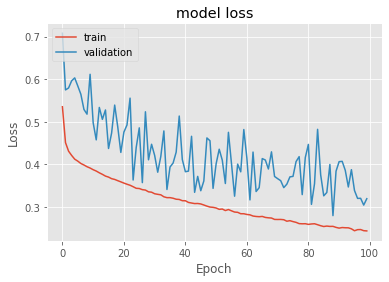

63/63 [==============================] - 0s 2ms/step - loss: 0.5157 - accuracy: 0.7910


<IPython.core.display.Javascript object>

In [134]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = estimator_v5.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.312135, G-Mean=0.720


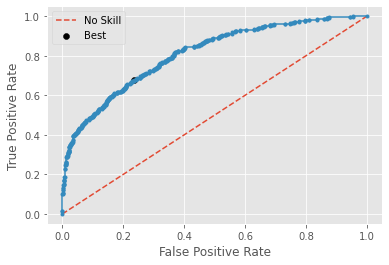

<IPython.core.display.Javascript object>

In [135]:
# predict probabilities
yhat1 = estimator_v5.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [136]:
y_pred=estimator_v5.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 3ms/step


array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

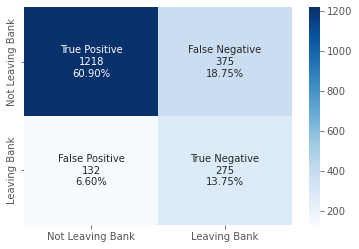

<IPython.core.display.Javascript object>

In [137]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [138]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1593
           1       0.42      0.68      0.52       407

    accuracy                           0.75      2000
   macro avg       0.66      0.72      0.67      2000
weighted avg       0.80      0.75      0.77      2000



<IPython.core.display.Javascript object>

In [139]:
save_classification_report(cr,'Model 5')

<IPython.core.display.Javascript object>

In [140]:
for r in classification_reports:
    print(r)

     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76
     model   class precision recall f1_score support accuracy
0  Model 2       0      0.92    0.8     0.86  1593.0         
1  Model 2       1      0.49   0.73     0.58   407.0         
2                                                        0.79
     model   class precision recall f1_score support accuracy
0  Model 3       0      0.93   0.77     0.84  1593.0         
1  Model 3       1      0.46   0.77     0.58   407.0         
2                                                        0.77
     model   class precision recall f1_score support accuracy
0  Model 4       0      0.92   0.77     0.84  1593.0         
1  Model 4       1      0.45   0.74     0.56   407.0         
2                                                        0.77
     mod

<IPython.core.display.Javascript object>

## Model 6

Try using the Keras Tuner

In [141]:
backend.clear_session()
np.random.seed(42)
#random.seed(42)
tf.random.set_seed(42)

<IPython.core.display.Javascript object>

In [142]:
def build_model(h):
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

<IPython.core.display.Javascript object>

In [143]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    project_name='Job_1')

<IPython.core.display.Javascript object>

In [144]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


<IPython.core.display.Javascript object>

In [145]:
### Searching the best model on X and y train
tuner.search(X_train, y_train,
             epochs=5,
             validation_split = 0.2)

Trial 5 Complete [00h 00m 23s]
val_accuracy: 0.856249988079071

Best val_accuracy So Far: 0.856249988079071
Total elapsed time: 00h 01m 41s
INFO:tensorflow:Oracle triggered exit


<IPython.core.display.Javascript object>

In [146]:
## Printing the best models with their hyperparameters
tuner.results_summary()

Results summary
Results in .\Job_1
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 8
units_0: 160
units_1: 224
learning_rate: 0.001
units_2: 160
units_3: 32
units_4: 192
units_5: 96
units_6: 192
units_7: 160
units_8: 160
Score: 0.856249988079071
Trial summary
Hyperparameters:
num_layers: 8
units_0: 160
units_1: 160
learning_rate: 0.001
units_2: 224
units_3: 96
units_4: 160
units_5: 64
units_6: 64
units_7: 192
units_8: 160
Score: 0.8554166754086813
Trial summary
Hyperparameters:
num_layers: 9
units_0: 192
units_1: 64
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
Score: 0.8552083174387614
Trial summary
Hyperparameters:
num_layers: 8
units_0: 64
units_1: 192
learning_rate: 0.0001
units_2: 64
units_3: 64
units_4: 224
units_5: 96
units_6: 128
units_7: 64
units_8: 224
Score: 0.8491666913032532
Trial summary
Hyperparameters:
num_layers: 2
units_0: 160
units_1: 256
learning_rate: 0.0001
Score: 0.8410416642824808


<IPython.core.display.Javascript object>

Create a model with parameters mentioned from the summary given by Keras Tuner.

In [147]:
backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

In [148]:
model6 = Sequential()
model6.add(Dense(160,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model6.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
model6.add(Dense(1, activation = 'sigmoid'))

<IPython.core.display.Javascript object>

In [149]:
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               1760      
                                                                 
 dense_1 (Dense)             (None, 256)               41216     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 43,233
Trainable params: 43,233
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [150]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model6.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [151]:
history_6 = model6.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
100/100 [==============================] - 2s 6ms/step - loss: 0.6756 - accuracy: 0.6644 - val_loss: 0.4846 - val_accuracy: 0.8006
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4515 - accuracy: 0.8156 - val_loss: 0.4511 - val_accuracy: 0.8138
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4297 - accuracy: 0.8233 - val_loss: 0.4342 - val_accuracy: 0.8175
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4151 - accuracy: 0.8306 - val_loss: 0.4210 - val_accuracy: 0.8256
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4021 - accuracy: 0.8345 - val_loss: 0.4091 - val_accuracy: 0.8356
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3921 - accuracy: 0.8370 - val_loss: 0.3996 - val_accuracy: 0.8425
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3817 - accuracy: 0.8427 - val_loss: 0.3938 - val_accuracy: 0.8394
Epoch 

<IPython.core.display.Javascript object>

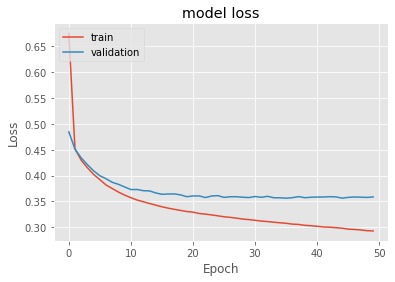

63/63 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.8590


<IPython.core.display.Javascript object>

In [152]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = model6.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.224735, G-Mean=0.767


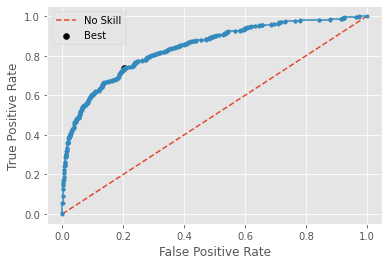

<IPython.core.display.Javascript object>

In [153]:
# predict probabilities
yhat1 = model6.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [154]:
y_pred=model6.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

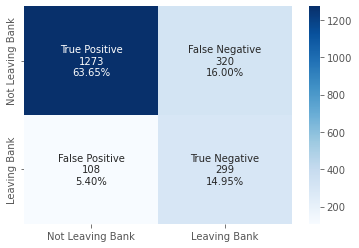

<IPython.core.display.Javascript object>

In [155]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [156]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.48      0.73      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.79      0.80      2000



<IPython.core.display.Javascript object>

In [157]:
save_classification_report(cr,'Model 6')

<IPython.core.display.Javascript object>

In [158]:
for r in classification_reports:
    print(r)

     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76
     model   class precision recall f1_score support accuracy
0  Model 2       0      0.92    0.8     0.86  1593.0         
1  Model 2       1      0.49   0.73     0.58   407.0         
2                                                        0.79
     model   class precision recall f1_score support accuracy
0  Model 3       0      0.93   0.77     0.84  1593.0         
1  Model 3       1      0.46   0.77     0.58   407.0         
2                                                        0.77
     model   class precision recall f1_score support accuracy
0  Model 4       0      0.92   0.77     0.84  1593.0         
1  Model 4       1      0.45   0.74     0.56   407.0         
2                                                        0.77
     mod

<IPython.core.display.Javascript object>

Model 2 and model 6 are tied for the best performance so far.  We will try one more model using the SMOTE dataset.

# Model 7

SMOTE + Keras Tuner

In [159]:
backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

<IPython.core.display.Javascript object>

In [160]:
def build_model(h):
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

<IPython.core.display.Javascript object>

In [161]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    project_name='Job_2')

<IPython.core.display.Javascript object>

In [162]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


<IPython.core.display.Javascript object>

In [163]:
smote=SMOTE(sampling_strategy='not majority')
X_sm , y_sm = smote.fit_resample(X_train,y_train)

<IPython.core.display.Javascript object>

In [164]:
### Searching the best model on SMOTE data
tuner.search(X_sm, y_sm,
             epochs=5,
             validation_split = 0.2)

Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.7349555095036825

Best val_accuracy So Far: 0.7447671492894491
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit


<IPython.core.display.Javascript object>

In [165]:
## Printing the best models with their hyperparameters
tuner.results_summary()

Results summary
Results in .\Job_2
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 128
units_1: 224
learning_rate: 0.001
units_2: 128
units_3: 192
units_4: 32
units_5: 128
units_6: 192
units_7: 128
Score: 0.7447671492894491
Trial summary
Hyperparameters:
num_layers: 8
units_0: 32
units_1: 192
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
Score: 0.7430664499600729
Trial summary
Hyperparameters:
num_layers: 7
units_0: 224
units_1: 128
learning_rate: 0.01
units_2: 128
units_3: 128
units_4: 160
units_5: 128
units_6: 128
units_7: 128
Score: 0.7358712752660116
Trial summary
Hyperparameters:
num_layers: 4
units_0: 32
units_1: 32
learning_rate: 0.001
units_2: 224
units_3: 64
units_4: 64
units_5: 128
units_6: 256
units_7: 32
Score: 0.7349555095036825
Trial summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 128
learning_rate: 0.0001
units_2: 96
units_3: 128
units_4: 224
units_5: 96
units_6: 192
units_7: 192
Scor

<IPython.core.display.Javascript object>

Create a model with parameters mentioned from the summary given by Keras Tuner.

In [166]:
model7 = Sequential()
model7.add(Dense(64,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model7.add(Dense(224,activation='relu',kernel_initializer='he_uniform'))
model7.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
model7.add(Dense(160,activation='relu',kernel_initializer='he_uniform'))
model7.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
model7.add(Dense(1, activation = 'sigmoid'))

<IPython.core.display.Javascript object>

In [168]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                704       
                                                                 
 dense_6 (Dense)             (None, 224)               14560     
                                                                 
 dense_7 (Dense)             (None, 256)               57600     
                                                                 
 dense_8 (Dense)             (None, 160)               41120     
                                                                 
 dense_9 (Dense)             (None, 256)               41216     
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 155,457
Trainable params: 155,457
Non-tr

<IPython.core.display.Javascript object>

In [169]:
optimizer = tf.keras.optimizers.Adam(0.001)
model7.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [170]:
history_7 = model7.fit(X_sm,y_sm,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
160/160 [==============================] - 3s 8ms/step - loss: 0.4835 - accuracy: 0.7617 - val_loss: 0.5505 - val_accuracy: 0.7331
Epoch 2/50
160/160 [==============================] - 1s 6ms/step - loss: 0.4126 - accuracy: 0.8096 - val_loss: 0.5807 - val_accuracy: 0.7261
Epoch 3/50
160/160 [==============================] - 1s 6ms/step - loss: 0.3788 - accuracy: 0.8292 - val_loss: 0.5906 - val_accuracy: 0.7037
Epoch 4/50
160/160 [==============================] - 1s 6ms/step - loss: 0.3577 - accuracy: 0.8389 - val_loss: 0.4193 - val_accuracy: 0.8104
Epoch 5/50
160/160 [==============================] - 1s 6ms/step - loss: 0.3315 - accuracy: 0.8510 - val_loss: 0.6330 - val_accuracy: 0.7029
Epoch 6/50
160/160 [==============================] - 1s 6ms/step - loss: 0.3029 - accuracy: 0.8663 - val_loss: 0.4431 - val_accuracy: 0.7932
Epoch 7/50
160/160 [==============================] - 1s 6ms/step - loss: 0.2800 - accuracy: 0.8791 - val_loss: 0.4480 - val_accuracy: 0.8112
Epoch 

<IPython.core.display.Javascript object>

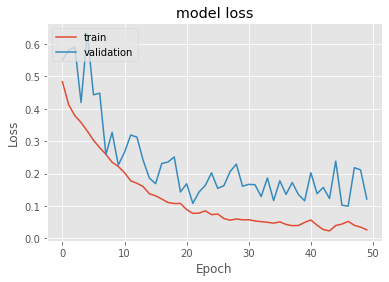

63/63 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.8590


<IPython.core.display.Javascript object>

In [171]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
results = model6.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.000987, G-Mean=0.713


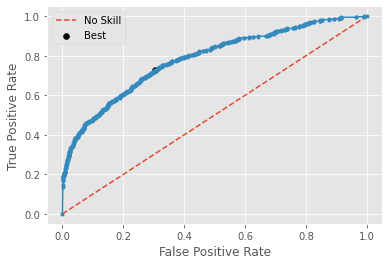

<IPython.core.display.Javascript object>

In [172]:
# predict probabilities
yhat1 = model7.predict(X_test)
# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]
# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)
# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [173]:
y_pred=model7.predict(X_test)
y_pred = (y_pred > thresholds1[ix])
y_pred

63/63 [==============================] - 0s 4ms/step


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [ True],
       [False]])

<IPython.core.display.Javascript object>

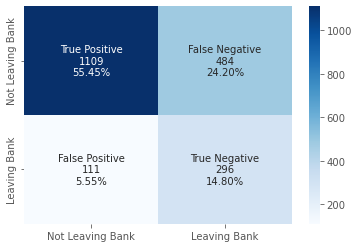

<IPython.core.display.Javascript object>

In [174]:
#Calculating the confusion matrix
cm=confusion_matrix(y_test, y_pred)
labels = ['True Positive','False Negative','False Positive','True Negative']
categories = [ 'Not Leaving Bank','Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [175]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.73      0.50       407

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000



<IPython.core.display.Javascript object>

Model 7 does offer anything better and the class 1 precision is lower than in model 6.

In [176]:
save_classification_report(cr,'Model 7')

<IPython.core.display.Javascript object>

## Model Performance Evaluation

In [177]:
for r in classification_reports:
    print(r)

     model   class precision recall f1_score support accuracy
0  Model 1       0      0.92   0.77     0.84  1593.0         
1  Model 1       1      0.45   0.74     0.56   407.0         
2                                                        0.76
     model   class precision recall f1_score support accuracy
0  Model 2       0      0.92    0.8     0.86  1593.0         
1  Model 2       1      0.49   0.73     0.58   407.0         
2                                                        0.79
     model   class precision recall f1_score support accuracy
0  Model 3       0      0.93   0.77     0.84  1593.0         
1  Model 3       1      0.46   0.77     0.58   407.0         
2                                                        0.77
     model   class precision recall f1_score support accuracy
0  Model 4       0      0.92   0.77     0.84  1593.0         
1  Model 4       1      0.45   0.74     0.56   407.0         
2                                                        0.77
     mod

<IPython.core.display.Javascript object>

Out of all the models, model 2 has the highest accurary and the best F1 scores.  Model 6 is almost identical in performance.

# Conclusion

The bank can use model 2 to identify with a reasonable degree of accuracy whether a customer will leave the bank or not.  This will help to reduce profit loss.

Other Takeaways:

* 76% of inactive customers are found in the low and middle credit score groups.
* Almost all inactive customers are found in the low and middle age groups.
* 70% of inactive customers had a high account balance compared to about 57% of active customers.
* 76% of inactive customers have middle to high estimated salaries.

The sales department should use these additional factors along with the model to target customers who are likely to leave and offer incentives to keep them. 